In [27]:
Phi0

2.0749999999999996e-15

In [36]:
%matplotlib notebook
import logging

from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA
from matplotlib import cm
import scqubits as scq
from scipy.optimize import curve_fit
from quantum_builder import QuantumBuilder
import ipywidgets
import matplotlib.gridspec as gridspec
import os

plt.style.use('support-files/qubit.mplstyle')

FLUX = float
FLUX_NUMBER = int

cos = np.cos
sin = np.sin
pi = np.pi

fF = 10 ** (-15)
c = 10**(-10) #F/m Capacitance on interface
h = 6.64 * 10**(-34)
e = 1.6 * 10**(-19)
um = 10**(-6)
GHz = 10**(9)
kOhm = 10**3
Rq = 6.484*kOhm
Delta = 3.1*10**(-23) # Superconducting delta
Phi0 = h/(2 * e)
Gauss = 10**(-4) # Gauss to Wb/m²

MY_COLOURS = {
    "DarkBlue": "#104e8b",     # dark blue (DodgerBlue4)
    "DarkRed": "#ed2200",     # dark red (red2)
    "Green": "#9acd32",     
    "Orange": "#ffc125",      # orange,
    "LightBlue": "#68838b",  # light steel blue,
    "Purple": "#6959cd",  # dark purple
    "Pink": "#ffa07a"  # pink salmon
}
CMAPS =  ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
COLORMAP_01 = ["#79cdcd", "#eead0e", "#9a37ff", "#00ee76"]
COLORMAP_12 = plt.get_cmap('Reds')
COLORMAP_ENERGY = plt.get_cmap('viridis')
COLORMAP_STATE = plt.get_cmap('hsv')

R_square_room_temperature = {'Dynamic-20sccm': 6700.0, 'Static-0.4mBar': 17000, 'Static-0.25mBar': 12170.0, 'Static-0.1mBar': 5670.0, 'Static-0.13mBar': 8000}
RESISTANCE_COLD_SCALING = 1.1

def eval_expected_ej0(resistance_rt):
    EJ0 = Rq / (resistance_rt * RESISTANCE_COLD_SCALING) * Delta / 2
    return EJ0/h/GHz

def eval_resitance_from_ej0(x_side: float, y_side: float, EJ0: float):
    N_squares= x_side/100 * y_side/100
    EJ0 = EJ0 * h * GHz
    return Rq * N_squares * Delta / 2 / EJ0 / kOhm

def c_interdigitated(W: float, L: float, N: int):
    return c * N * (W + L)

def ec_interdigitated(W: float, L: float, N: int):
    C = c * N * (W + L)
    Ec = e**2 / (2 * C) / h / GHz
    return Ec

GHz = 10**9

#plt.style.use('support-files/qubit.mplstyle')

def to_dBm(array):
    # Conver to dBm. Values smaller than 0 are set to the lowest value in array
    min_value = 10 * np.log10(min(array[array > 0]))
    return 10 * np.nan_to_num(np.log10(array), nan = min_value, neginf=min_value)

def from_dBm(array):
    return np.power(10, array / 10)

def rabi_model(t, tDec, T, A, B, C, D, *args):
    """
    __ Description __
    Fits Rabi oscillations of the format
    A e^(-t/tDec) cos(2π t / T + B) + C
    """

    return A * np.sin(2 * np.pi * t / T + B) * np.exp(-t / tDec) + C*t + D

def rabi_model_beating(t, t_dec, T, A, B, C, D, E, t_beat):
    """
    OLD! Need to move t_beat to the end!
    __ Description __
    Fits Rabi oscillations of the format
    A e^(-t/tDec) cos(2π t / T + B)sin(2π t / t_beat + E) + Ct + D
    """

    return A * np.sin(2 * np.pi * t / T + B) * np.sin(2 * np.pi * t / t_beat + E) *  np.exp(-t / t_dec) + C*t + D

# Old Photon Source (cell Ay)

## Mfield

<IPython.core.display.Javascript object>


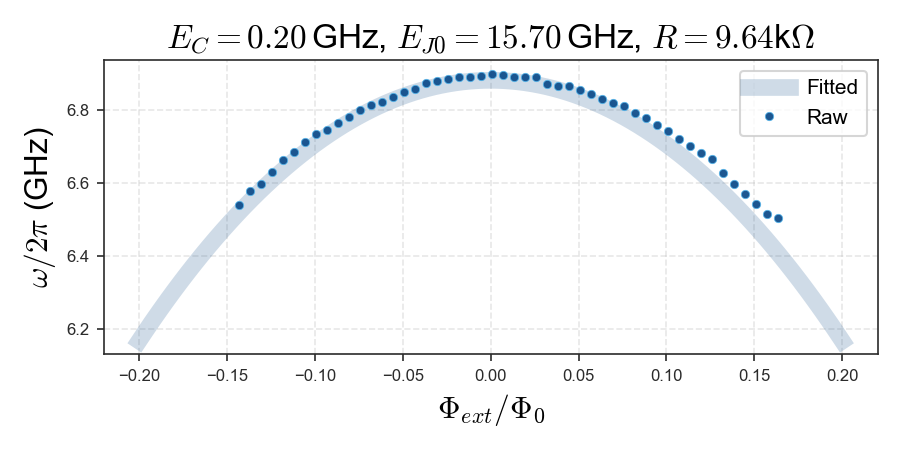

In [35]:
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_02_mfield-sweep.vi.txt"

# Fabrication Parameters
RESISTANCE_RT = 5.67*kOhm
JJ_side = 100
#AREA_LOOP = 4.2*um * 5.8*um
L = 40*um
W = 10*um
N = 25

# Fitting Parameters
OFFSET = 0.091
MULTIPLIER = 12.5
EC = 0.2
EJ0 = 15.7
FLUX_LIST = np.linspace(-0.2, 0.2, 101)

# loaded
with open(FILENAME) as fin:
    lines = (line for line in fin if not line.startswith('#'))
    experiment_data = np.loadtxt(lines)
experiment_x = (experiment_data[:, 0] - OFFSET) * MULTIPLIER
experiment_y = experiment_data[:, 1]

# Fitting
fitted = scq.TunableTransmon(
    EJmax=2*EJ0,
    EC=EC,
    d=0,       # no assymerty
    flux=0.0,  # defaults
    ng=0.0,
    ncut=21
)
fitted_01 = fitted.get_spectrum_vs_paramvals(param_name='flux',
                                                  param_vals=FLUX_LIST,
                                                  evals_count=2,
                                                  subtract_ground=True
                                                  ).energy_table[:, 1]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
fitted_plot, = ax.plot(FLUX_LIST, fitted_01,
        linestyle="-",
        color=MY_COLOURS["DarkBlue"],
        label="Fitted",
        linewidth=8,
        alpha=0.2
        )

experiment_plot, = ax.plot(experiment_x, experiment_y,
        marker="o",
        color=MY_COLOURS["DarkBlue"],
        markeredgecolor="C2",
        label="Raw",
        markeredgewidth="0.4", markersize=4, alpha=0.95,
        linestyle="")

ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.set_ylabel("$\omega/2\pi$ (GHz)", fontsize=15)
ax.set_title(f"$E_C={EC:.2f}\,$GHz, $E_{{J0}}={EJ0:.2f}\,$GHz, $R={eval_resitance_from_ej0(JJ_side, JJ_side, EJ0):.2f}$k$\Omega$", fontsize=16)
ax.legend()
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "pdf"))

In [34]:
CONTINUOUS_UPDATE = False
def update(EC, EJ0, offset, multiplier, toggle_experiment: bool):
    experiment_plot.set_xdata((experiment_data[:, 0]- offset) * multiplier)
    
    ax.set_title(f"$E_C={EC:.2f}\,$GHz, $E_{{J0}}={EJ0:.2f}\,$GHz, $R={eval_resitance_from_ej0(JJ_side, JJ_side, EJ0):.2f}$k$\Omega$", fontsize=16)
    scq_energies = scq.TunableTransmon(
        EJmax=2*EJ0,
        EC=EC,
        d=0,       # no assymerty
        flux=0.0,  # defaults
        ng=0.0,
        ncut=21
        ).get_spectrum_vs_paramvals(param_name='flux',
                                                      param_vals=FLUX_LIST,
                                                      evals_count=2,
                                                      subtract_ground=True
                                                      ).energy_table
    fitted_plot.set_ydata(scq_energies[:, 1])
    
    ax.relim()
    ax.autoscale_view()
    
EC_widget = ipywidgets.FloatSlider(
    min=0.01, max=2, step=0.01,
    description="$E_{C}$ (GHz)", value=EC,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
EC_widget.style.handle_color = 'red'
EJ0_widget = ipywidgets.FloatSlider(
    min=1, max=100,
    description="$E_{J0}$ (GHz)", value=EJ0,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
EJ0_widget.style.handle_color = 'red'

offset_widget = ipywidgets.FloatSlider(
    min=0.05, max=0.2, step=0.001,
    readout_format='.4f',
    description="offset", value=OFFSET,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
multiplier_widget = ipywidgets.FloatSlider(
    min=0.1, max=20, step=0.1,
    description="multiplier", value=MULTIPLIER,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
toggle_widget = ipywidgets.Checkbox(
    description='Toggle Expected',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(5, 1)
ui[0, :] = EC_widget
ui[1, :] = EJ0_widget
ui[2, :] = offset_widget
ui[3, :] = multiplier_widget
ui[4, :] = toggle_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "EC": EC_widget,
        "EJ0": EJ0_widget,
        "offset": offset_widget,
        "multiplier": multiplier_widget,
        "toggle_experiment": toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatSlider(value=0.15421686746987956, continuous_update=False, description='$E_{C}$ …

Output()

## Rabi 

### Ay_12_rabi-freq-sweep_vna0dBm

In [97]:
RABI_MODEL = rabi_model
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_12_rabi-freq-sweep_vna0dBm.txt"
VARIABLE = "Frequency (GHz)"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f"data/cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

Loaded cached parameters!


 c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py: 828

<IPython.core.display.Javascript object>


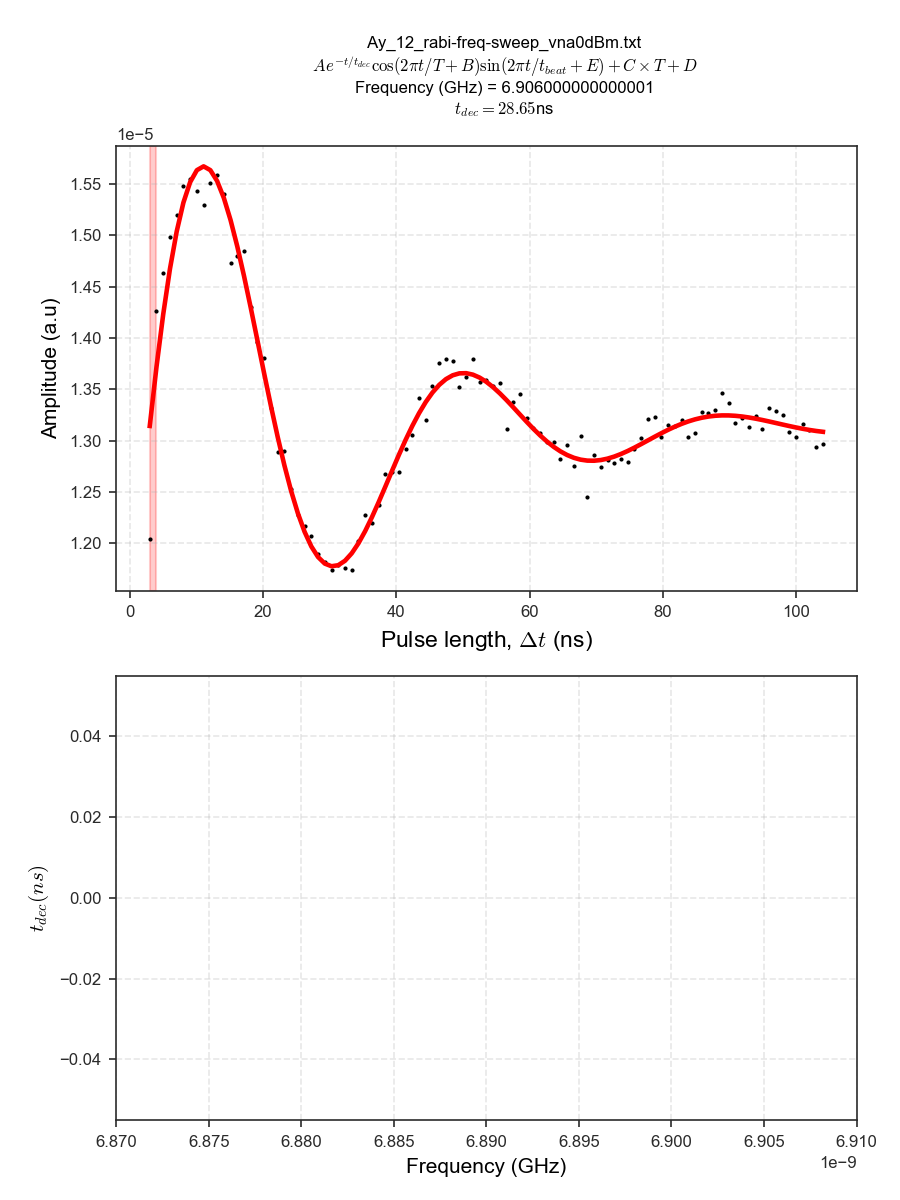

In [98]:
# Initial Guess
cut = (0, 1)
INDEX = 1
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    {VARIABLE} = {F_DATA[INDEX]}
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel(VARIABLE, fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        {VARIABLE} = {F_DATA[INDEX]}
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value/10**6, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f"data/cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

In [99]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[7, :] = INDEX_widget
ui[8, 0] = user_toggle_widget
ui[8, 1] = store_user_fit_widget
ui[8, 2] = fit_toggle_widget
ui[8, 3]= store_fit_widget
ui[9, :] = load_parameters_widget
ui[10, :] = dump_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

No parameters saved for this plot
Loaded parameters!: [26.05447695278395, 38.93601058104981, 4.179303256805026e-06, 5.837375531501815, 1.296353252430186e-09, 1.2998020531374029e-05, 1.5707963267948966, 8000.0]


<IPython.core.display.Javascript object>


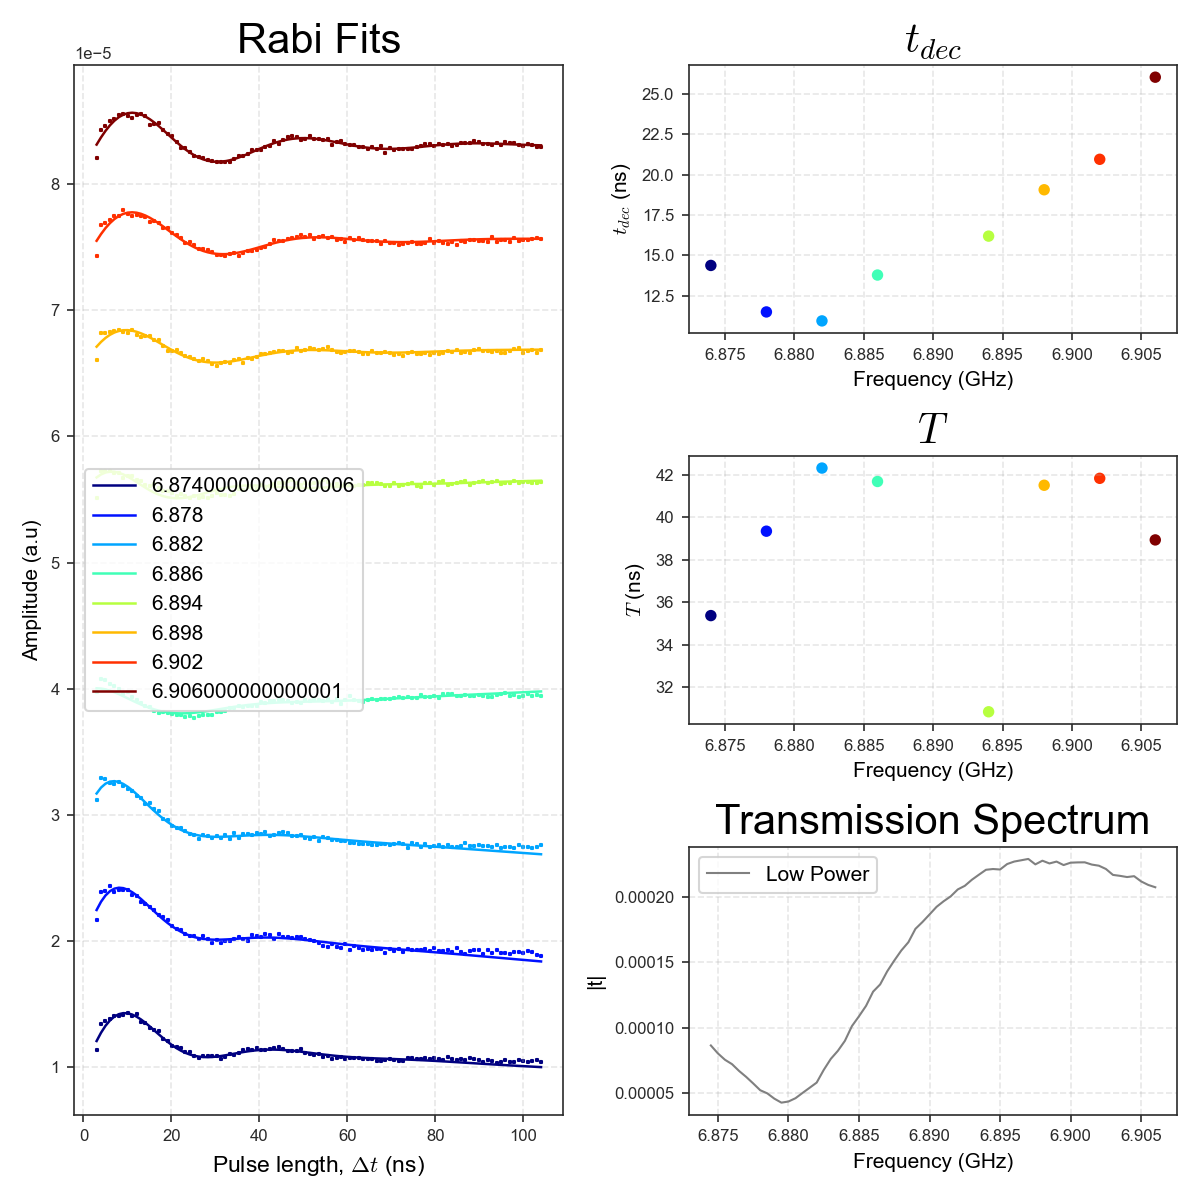

In [87]:
# Summarise the fittings:
SPACING = 0.00001
cmap = plt.cm.jet(np.linspace(0, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))
TRANSMISSION_FILE = "C:/ExperimentBlue/2021-08_photon-source/Ay_12_rabi-freq-sweep_vna0dBm_transmission.txt"

# Plot T, t_dec for different frequencies and the rabi plots
# fix, ax = plt.subplots(3, 1, figsize=(4,9))
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 2)

ax0 = plt.subplot(gs[:, 0])
ax0.set_title("Rabi Fits")
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax0.set_ylabel("Amplitude (a.u)", fontsize=10)

ax1 = plt.subplot(gs[0, 1])
ax1.set_title("$t_{dec}$")
ax1.set_xlabel(f"{VARIABLE}", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=10)

ax2 = plt.subplot(gs[1, 1])
ax2.set_title("$T$")
ax2.set_xlabel(f"{VARIABLE}", fontsize=10)
ax2.set_ylabel("$T$ (ns)", fontsize=10)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model(T_DATA, *val), color=cmap[i], label=F_DATA[idx])
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap) 

# Plot transmission
ax3 = plt.subplot(gs[2, 1])
ax3.set_title("Transmission Spectrum")
ax3.set_xlabel(VARIABLE, fontsize=10)
ax3.set_ylabel("|t|", fontsize=10)


transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
ax3.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='gray', label="Low Power")
ax3.legend()

# ax32 = ax3.twinx() 
# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax32.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='black', label="Rabi Power")

# ax32.axvline(res_original)
# ax1.axvline(res_original)
# ax2.axvline(res_original)

# ax32.axvline(res_rabi)
# ax1.axvline(res_rabi)
# ax2.axvline(res_rabi)

# ax32.legend(loc='upper left')
# ax3.legend(loc='lower right')
ax0.legend()
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "svg"))
plt.savefig(FILENAME.replace("txt", "pdf"))

### Ay_16_rabi-freq-sweep_vna-5dBm

In [92]:
RABI_MODEL = rabi_model
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_16_rabi-freq-sweep_vna-5dBm.txt"
VARIABLE = "Frequency (GHz)"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f"data/cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

<IPython.core.display.Javascript object>


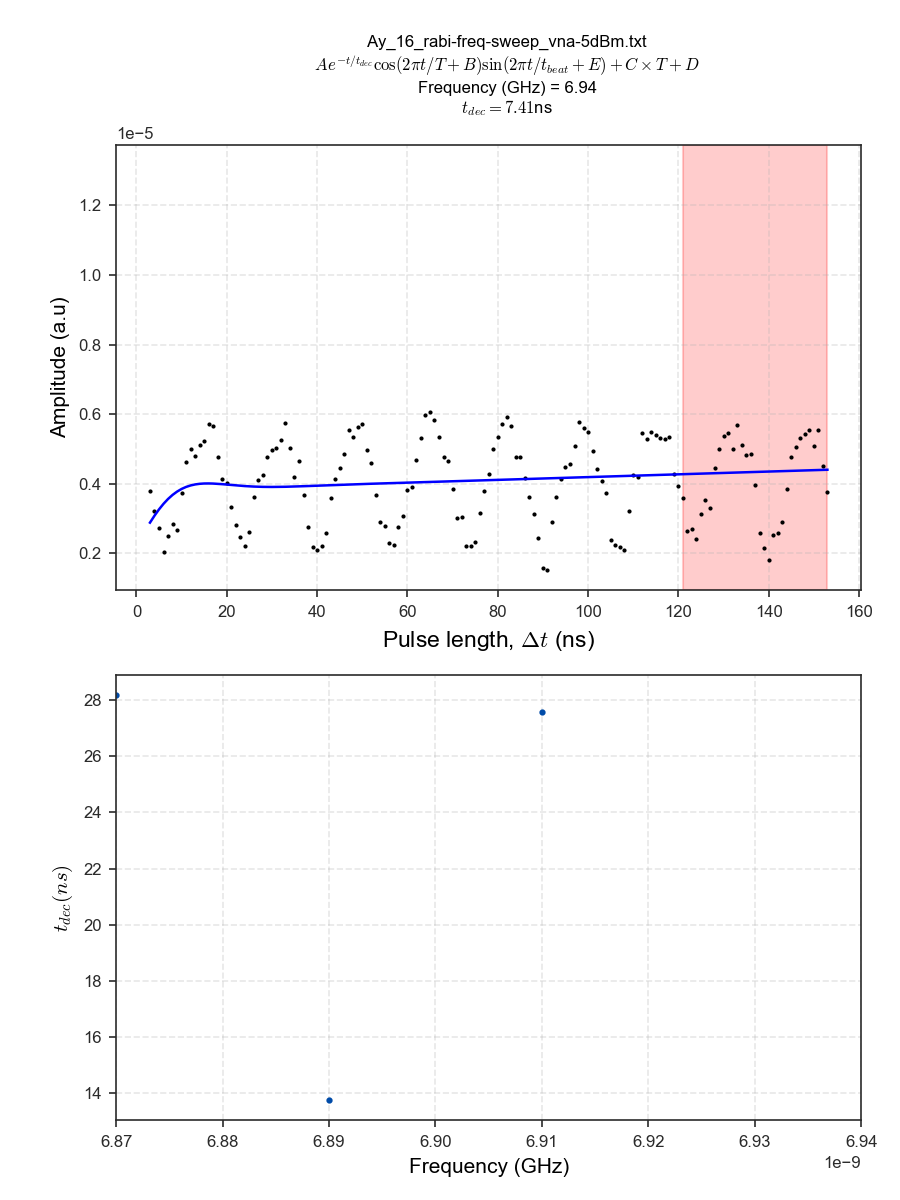

In [93]:
# Initial Guess
cut = (0, 1)
INDEX = 0
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    {VARIABLE} = {F_DATA[INDEX]}
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel(VARIABLE, fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        {VARIABLE} = {F_DATA[INDEX]}
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value/10**6, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f"data/cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

In [94]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[7, :] = INDEX_widget
ui[8, 0] = user_toggle_widget
ui[8, 1] = store_user_fit_widget
ui[8, 2] = fit_toggle_widget
ui[8, 3]= store_fit_widget
ui[9, :] = load_parameters_widget
ui[10, :] = dump_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

Stored parameters!{0: [32.207200187395294, 40.63651919778337, 2.9869586566399765e-06, 5.632346337810573, 7.373812867525572e-11, 1.3047237857662457e-05, 1.5707963267948966, 8000.0]}
Loaded parameters!: [32.207200187395294, 40.63651919778337, 2.9869586566399765e-06, 5.632346337810573, 7.373812867525572e-11, 1.3047237857662457e-05, 1.5707963267948966, 8000.0]
Stored parameters!{0: [28.735854437748987, 38.82797516579644, 3.338028191909515e-06, 5.229337472169338, -1.4660279172240134e-10, 1.3070773234115036e-05, 1.5707963267948966, 8000.0]}
Loaded parameters!: [28.735854437748987, 38.82797516579644, 3.338028191909515e-06, 5.229337472169338, -1.4660279172240134e-10, 1.3070773234115036e-05, 1.5707963267948966, 8000.0]
Stored parameters!{0: [28.161331573552822, 39.20032248271492, 3.5344864820203543e-06, 5.279772021572838, -1.8938712415373542e-10, 1.3074754024651494e-05, 1.5707963267948966, 8000.0]}
Loaded parameters!: [28.161331573552822, 39.20032248271492, 3.5344864820203543e-06, 5.27977202157

Loaded parameters!: [17.448381309394794, 17.078002623202437, 6.743145896757925e-07, 4.826385633985702, -9.234367585329002e-09, 1.1009641168763796e-05, 1.5707963267948966, 8000.0]
Stored parameters!{0: [28.161074087275068, 39.175768573070854, 3.5393284196719123e-06, 5.276548216558418, -1.891860439229396e-10, 1.3074755132740345e-05, 1.5707963267948966, 8000.0], 2: [13.770663884610356, 62.88485647858079, 7.015349687914249e-06, 6.312115703484213, 9.614793439000357e-09, 1.651543090033982e-05, 1.5707963267948966, 8000.0], 4: [17.448381309394794, 17.078002623202437, 6.743145896757925e-07, 4.826385633985702, -9.234367585329002e-09, 1.1009641168763796e-05, 1.5707963267948966, 8000.0]}
Loaded parameters!: [17.448381309394794, 17.078002623202437, 6.743145896757925e-07, 4.826385633985702, -9.234367585329002e-09, 1.1009641168763796e-05, 1.5707963267948966, 8000.0]
Stored parameters!{0: [28.161074087275068, 39.175768573070854, 3.5393284196719123e-06, 5.276548216558418, -1.891860439229396e-10, 1.3074

<IPython.core.display.Javascript object>


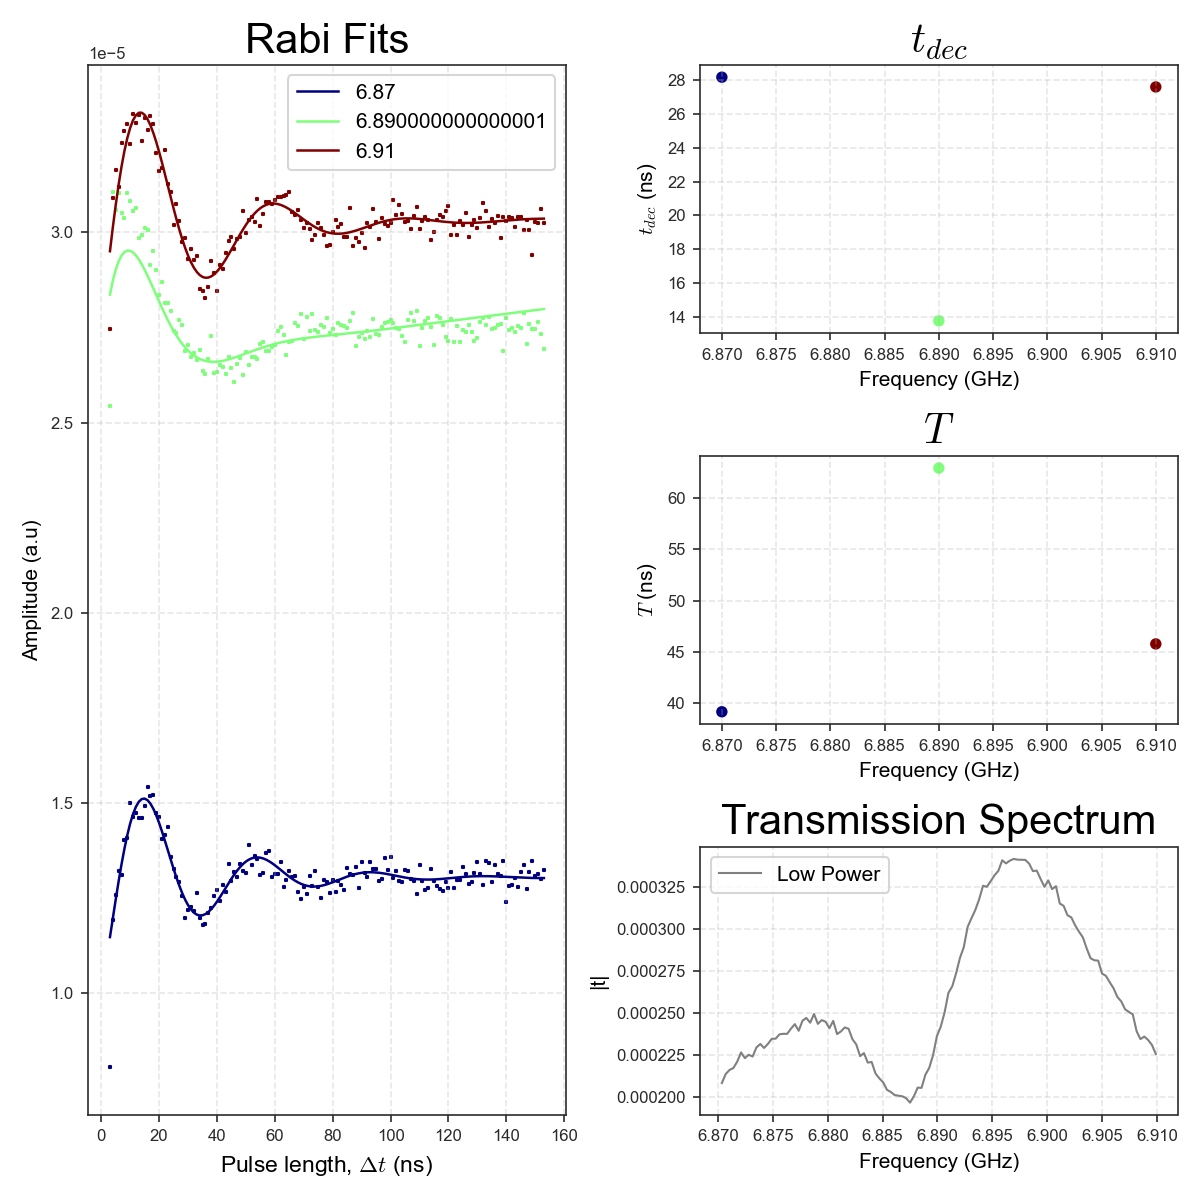

In [96]:
# Summarise the fittings:
SPACING = 0.00001
cmap = plt.cm.jet(np.linspace(0, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))
TRANSMISSION_FILE = "C:/ExperimentBlue/2021-08_photon-source/Ay_16_rabi-freq-sweep_vna-5dBm_transmission.txt"

# Plot T, t_dec for different frequencies and the rabi plots
# fix, ax = plt.subplots(3, 1, figsize=(4,9))
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 2)

ax0 = plt.subplot(gs[:, 0])
ax0.set_title("Rabi Fits")
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax0.set_ylabel("Amplitude (a.u)", fontsize=10)

ax1 = plt.subplot(gs[0, 1])
ax1.set_title("$t_{dec}$")
ax1.set_xlabel(f"{VARIABLE}", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=10)

ax2 = plt.subplot(gs[1, 1])
ax2.set_title("$T$")
ax2.set_xlabel(f"{VARIABLE}", fontsize=10)
ax2.set_ylabel("$T$ (ns)", fontsize=10)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model(T_DATA, *val), color=cmap[i], label=F_DATA[idx])
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap) 

# Plot transmission
ax3 = plt.subplot(gs[2, 1])
ax3.set_title("Transmission Spectrum")
ax3.set_xlabel(VARIABLE, fontsize=10)
ax3.set_ylabel("|t|", fontsize=10)


transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
ax3.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='gray', label="Low Power")
ax3.legend()

# ax32 = ax3.twinx() 
# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax32.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='black', label="Rabi Power")

# ax32.axvline(res_original)
# ax1.axvline(res_original)
# ax2.axvline(res_original)

# ax32.axvline(res_rabi)
# ax1.axvline(res_rabi)
# ax2.axvline(res_rabi)

# ax32.legend(loc='upper left')
# ax3.legend(loc='lower right')
ax0.legend()
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "svg"))
plt.savefig(FILENAME.replace("txt", "pdf"))

### Ay_18_rabi-freq-sweep_vna0dBm_keysight4MHz
- Best fit obtained for 6.915GHz (which is quite a bit off resonance)

In [103]:
RABI_MODEL = rabi_model
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_18_rabi-freq-sweep_vna0dBm_keysight4MHz.txt"
VARIABLE = "Frequency (GHz)"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f"data/cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

<IPython.core.display.Javascript object>


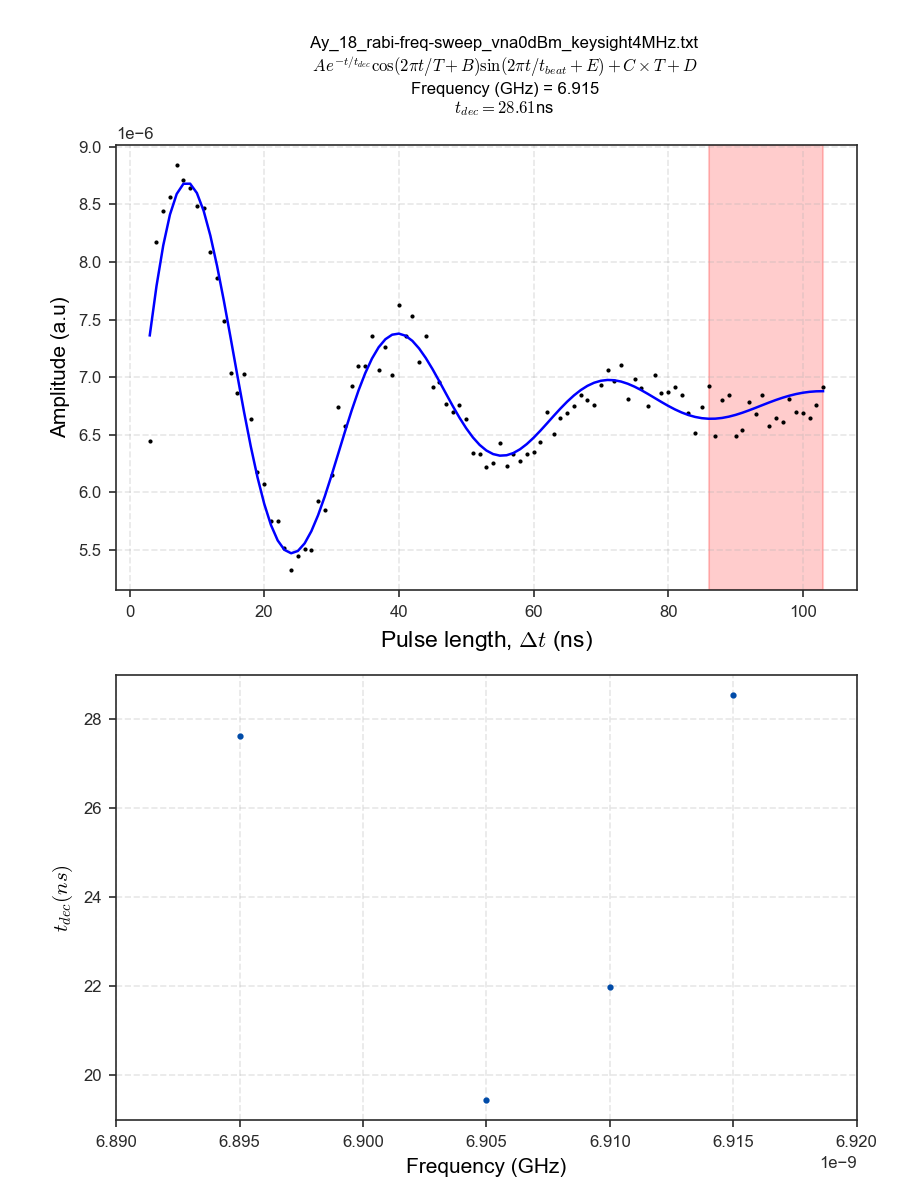

In [106]:
# Initial Guess
cut = (0, 1)
INDEX = 1
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    {VARIABLE} = {F_DATA[INDEX]}
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel(VARIABLE, fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        {VARIABLE} = {F_DATA[INDEX]}
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f"data/cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

In [107]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[7, :] = INDEX_widget
ui[8, 0] = user_toggle_widget
ui[8, 1] = store_user_fit_widget
ui[8, 2] = fit_toggle_widget
ui[8, 3]= store_fit_widget
ui[9, :] = load_parameters_widget
ui[10, :] = dump_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

Stored parameters!{1: [1.6618176050529883, 34.972433018045656, -9.430295999240102e-07, 2.951378182890015, 5.733707943875198e-09, 1.3193995265621979e-05, 1.5707963267948966, 8000.0]}
Loaded parameters!: [1.6618176050529883, 34.972433018045656, -9.430295999240102e-07, 2.951378182890015, 5.733707943875198e-09, 1.3193995265621979e-05, 1.5707963267948966, 8000.0]
Stored parameters!{1: [1.6618176050529883, 34.972433018045656, -9.430295999240102e-07, 2.951378182890015, 5.733707943875198e-09, 1.3193995265621979e-05, 1.5707963267948966, 8000.0]}
Loaded parameters!: [1.6618176050529883, 34.972433018045656, -9.430295999240102e-07, 2.951378182890015, 5.733707943875198e-09, 1.3193995265621979e-05, 1.5707963267948966, 8000.0]
Stored parameters!{1: [27.63041613244465, 32.562833453876785, -1.8674017005656782e-06, 2.698204193047384, 5.594375029230068e-09, 1.3202033307733128e-05, 1.5707963267948966, 8000.0]}
Loaded parameters!: [27.63041613244465, 32.562833453876785, -1.8674017005656782e-06, 2.698204193

Loaded parameters!: [19.44682821538592, 37.292542138275834, 4.5239934263222426e-06, 5.6717001525941395, 3.3269037553895727e-09, 1.1248390413593793e-05, 1.5707963267948966, 8000.0]
Parameters saved to file: 'data/cache/Ay_18_rabi-freq-sweep_vna0dBm_keysight4MHz.txt.cache'
Stored parameters!{1: [27.63041613244465, 32.562833453876785, -1.8674017005656782e-06, 2.698204193047384, 5.594375029230068e-09, 1.3202033307733128e-05, 1.5707963267948966, 8000.0], 3: [19.44682821538592, 37.292542138275834, 4.5239934263222426e-06, 5.6717001525941395, 3.3269037553895727e-09, 1.1248390413593793e-05, 1.5707963267948966, 8000.0], 4: [21.983656338159104, 33.41388780868905, 3.520252357992773e-06, 5.759812743867349, 1.0868519124677906e-09, 8.825316251162044e-06, 1.5707963267948966, 8000.0]}
Parameters saved to file: 'data/cache/Ay_18_rabi-freq-sweep_vna0dBm_keysight4MHz.txt.cache'
No parameters saved for this plot
Stored parameters!{1: [27.63041613244465, 32.562833453876785, -1.8674017005656782e-06, 2.698204

Loaded parameters!: [19.44682821538592, 37.292542138275834, 4.5239934263222426e-06, 5.6717001525941395, 3.3269037553895727e-09, 1.1248390413593793e-05, 1.5707963267948966, 8000.0]
Loaded parameters!: [21.983656338159104, 33.41388780868905, 3.520252357992773e-06, 5.759812743867349, 1.0868519124677906e-09, 8.825316251162044e-06, 1.5707963267948966, 8000.0]
Loaded parameters!: [28.530614969274918, 31.276461728325256, 2.810589488151516e-06, 5.976933351639059, 1.7916178937824639e-09, 6.617793083794819e-06, 1.5707963267948966, 8000.0]


<IPython.core.display.Javascript object>


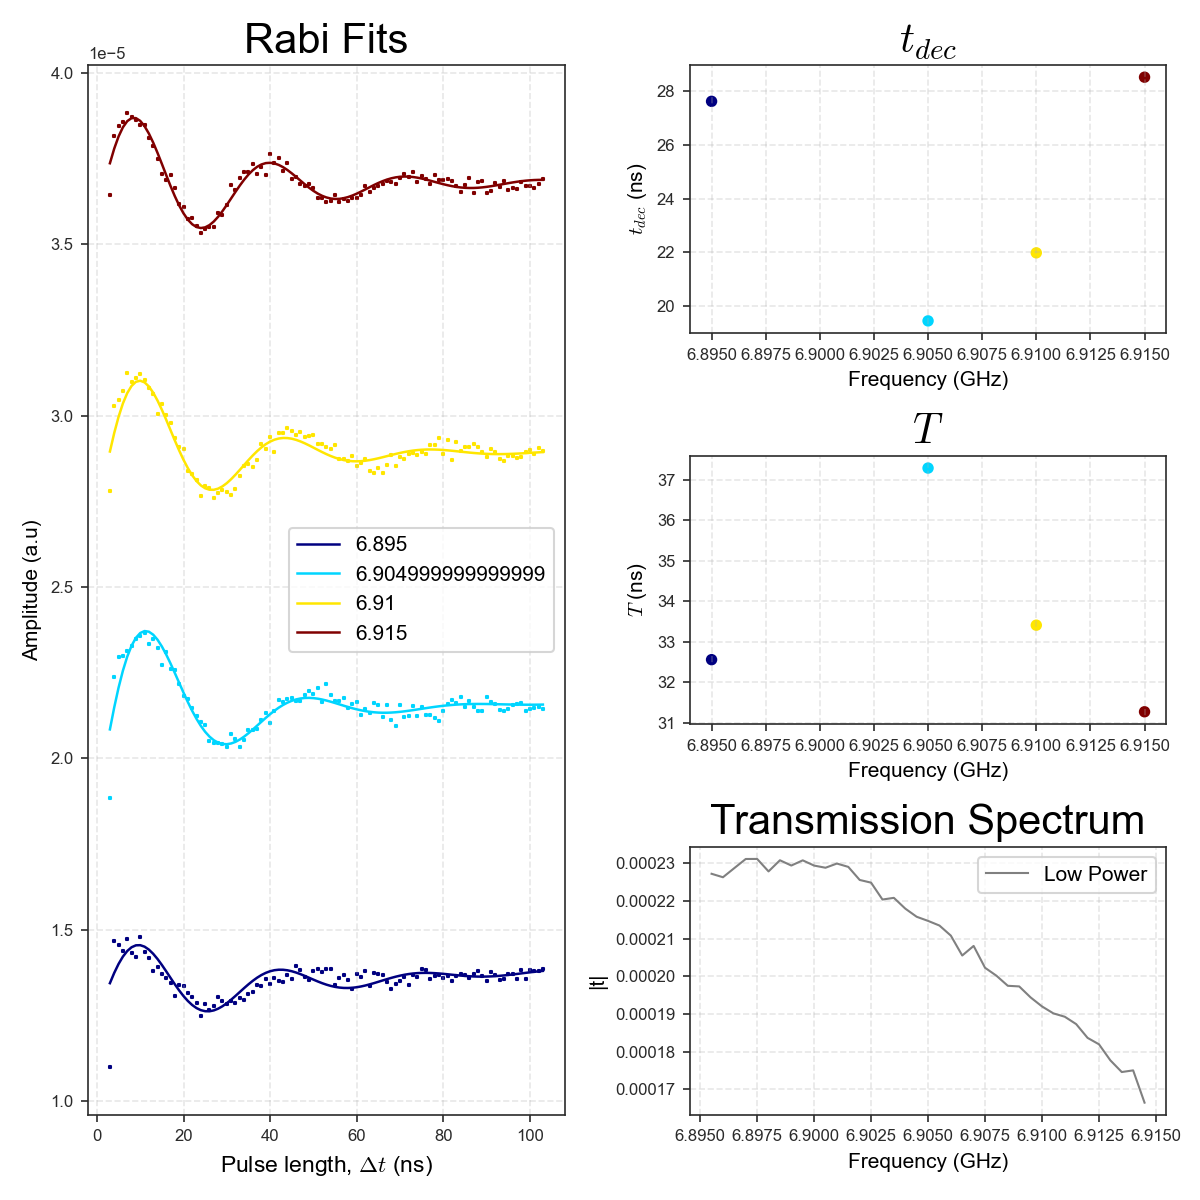

In [108]:
# Summarise the fittings:
SPACING = 0.00001
cmap = plt.cm.jet(np.linspace(0, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))
TRANSMISSION_FILE = "C:/ExperimentBlue/2021-08_photon-source/Ay_18_rabi-freq-sweep_vna0dBm_keysight4MHz_transmission.txt"

# Plot T, t_dec for different frequencies and the rabi plots
# fix, ax = plt.subplots(3, 1, figsize=(4,9))
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 2)

ax0 = plt.subplot(gs[:, 0])
ax0.set_title("Rabi Fits")
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax0.set_ylabel("Amplitude (a.u)", fontsize=10)

ax1 = plt.subplot(gs[0, 1])
ax1.set_title("$t_{dec}$")
ax1.set_xlabel(f"{VARIABLE}", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=10)

ax2 = plt.subplot(gs[1, 1])
ax2.set_title("$T$")
ax2.set_xlabel(f"{VARIABLE}", fontsize=10)
ax2.set_ylabel("$T$ (ns)", fontsize=10)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model(T_DATA, *val), color=cmap[i], label=F_DATA[idx])
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap) 

# Plot transmission
ax3 = plt.subplot(gs[2, 1])
ax3.set_title("Transmission Spectrum")
ax3.set_xlabel(VARIABLE, fontsize=10)
ax3.set_ylabel("|t|", fontsize=10)


transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
ax3.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='gray', label="Low Power")
ax3.legend()

# ax32 = ax3.twinx() 
# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax32.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='black', label="Rabi Power")

# ax32.axvline(res_original)
# ax1.axvline(res_original)
# ax2.axvline(res_original)

# ax32.axvline(res_rabi)
# ax1.axvline(res_rabi)
# ax2.axvline(res_rabi)

# ax32.legend(loc='upper left')
# ax3.legend(loc='lower right')
ax0.legend()
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "svg"))
plt.savefig(FILENAME.replace("txt", "pdf"))

### Ay_19_rabi-keysight-sweep
2-4MHz gave results

In [112]:
RABI_MODEL = rabi_model
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_19_rabi-keysight-sweep.txt"
VARIABLE = "Keysight Frequency (MHz)"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f"data/cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

<IPython.core.display.Javascript object>


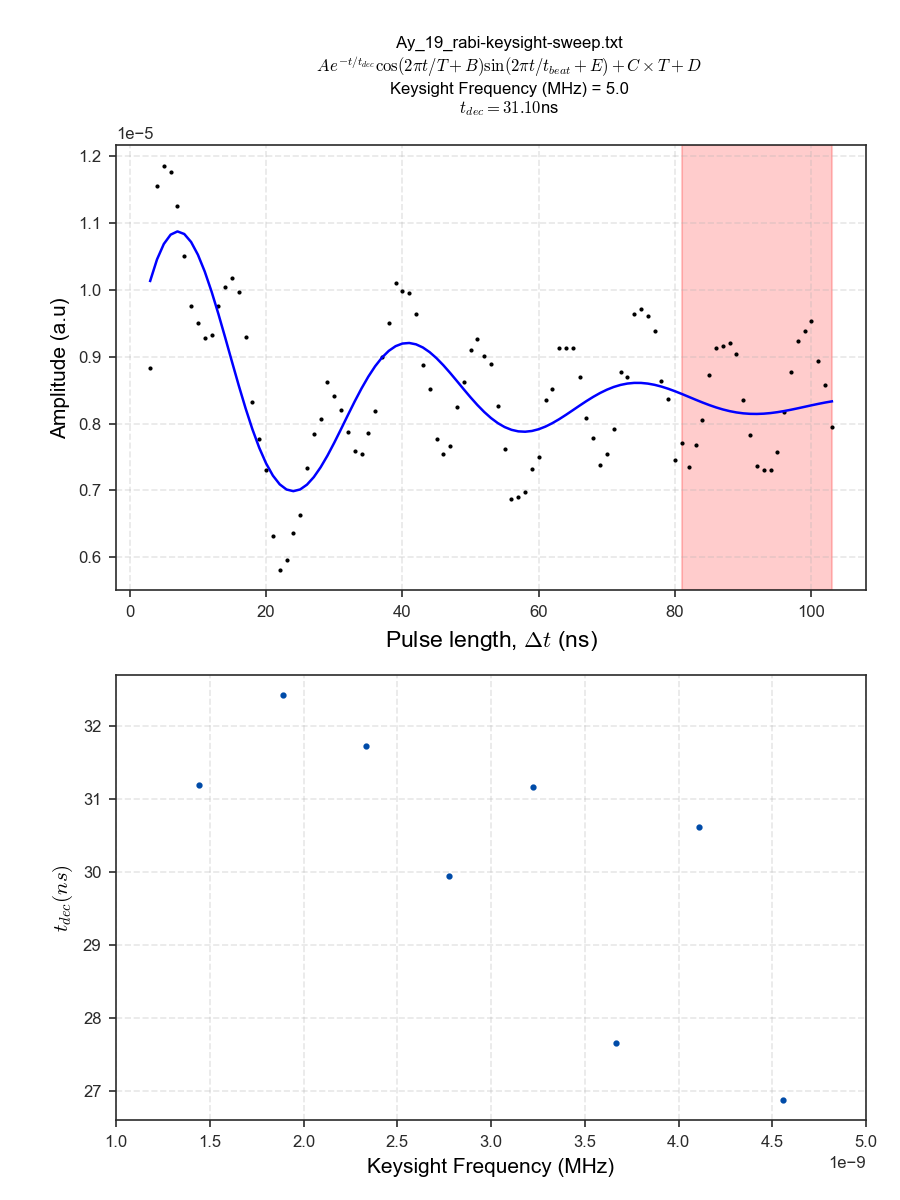

In [113]:
# Initial Guess
cut = (0, 1)
INDEX = 1
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    {VARIABLE} = {F_DATA[INDEX]}
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel(VARIABLE, fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        {VARIABLE} = {F_DATA[INDEX]}
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value/10**6, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f"data/cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

In [114]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[7, :] = INDEX_widget
ui[8, 0] = user_toggle_widget
ui[8, 1] = store_user_fit_widget
ui[8, 2] = fit_toggle_widget
ui[8, 3]= store_fit_widget
ui[9, :] = load_parameters_widget
ui[10, :] = dump_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

Stored parameters!{1: [19.085675031788497, 34.955504642934116, 2.7449783159954003e-07, 4.499436556638014, -6.109030809429669e-10, 2.3732342813017823e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [19.085675031788497, 34.955504642934116, 2.7449783159954003e-07, 4.499436556638014, -6.109030809429669e-10, 2.3732342813017823e-06, 1.5707963267948966, 8000.0]
Stored parameters!{1: [19.085675031788497, 34.955504642934116, 2.7449783159954003e-07, 4.499436556638014, -6.109030809429669e-10, 2.3732342813017823e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [19.085675031788497, 34.955504642934116, 2.7449783159954003e-07, 4.499436556638014, -6.109030809429669e-10, 2.3732342813017823e-06, 1.5707963267948966, 8000.0]
Stored parameters!{1: [4.7566417005220245, 69.55959044101778, -1.1613341396929732e-06, 4.176365952560383, -6.704485367114101e-10, 2.3772457669998894e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [4.7566417005220245, 69.55959044101778, -1.1613341396929732e-06, 4.1763

Parameters saved to file: 'data/cache/Ay_19_rabi-keysight-sweep.txt.cache'
Stored parameters!{1: [31.191512207867138, 30.318381683069568, -1.0423165124178087e-06, 2.6295507184946536, -4.5702167753826994e-10, 2.3535231956188604e-06, 1.5707963267948966, 8000.0], 2: [32.4206522542139, 32.30411556496245, -1.1711914338934523e-06, 3.178135564930471, -1.0433356869445113e-09, 3.170759393253644e-06, 1.5707963267948966, 8000.0], 3: [31.722605166383513, 32.94582154802421, -1.501400555348178e-06, 3.1328257067405216, -1.1099241295318489e-10, 3.888621940789789e-06, 1.5707963267948966, 8000.0], 4: [29.96242665247557, 31.9548308922469, -1.7699971854538121e-06, 2.9785126619847997, 1.0998205108452324e-09, 4.558456918043562e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [29.96242665247557, 31.9548308922469, -1.7699971854538121e-06, 2.9785126619847997, 1.0998205108452324e-09, 4.558456918043562e-06, 1.5707963267948966, 8000.0]
Stored parameters!{1: [31.191512207867138, 30.318381683069568, -1.0423165

Loaded parameters!: [30.62257579889301, 32.019441006081486, -2.7512191707667e-06, 2.962566394140464, 5.385750950769997e-10, 6.791295233925905e-06, 1.5707963267948966, 8000.0]
Stored parameters!{1: [31.191512207867138, 30.318381683069568, -1.0423165124178087e-06, 2.6295507184946536, -4.5702167753826994e-10, 2.3535231956188604e-06, 1.5707963267948966, 8000.0], 2: [32.4206522542139, 32.30411556496245, -1.1711914338934523e-06, 3.178135564930471, -1.0433356869445113e-09, 3.170759393253644e-06, 1.5707963267948966, 8000.0], 3: [31.722605166383513, 32.94582154802421, -1.501400555348178e-06, 3.1328257067405216, -1.1099241295318489e-10, 3.888621940789789e-06, 1.5707963267948966, 8000.0], 4: [29.945637641263513, 32.11444491483222, -1.7879442100416367e-06, 3.0009322839650525, 1.1524916318597316e-09, 4.556623287485285e-06, 1.5707963267948966, 8000.0], 5: [31.16709146557733, 32.30376997532014, -2.0569357076663093e-06, 3.063890719447881, -4.754569417172928e-10, 5.407123669894038e-06, 1.57079632679489

<IPython.core.display.Javascript object>


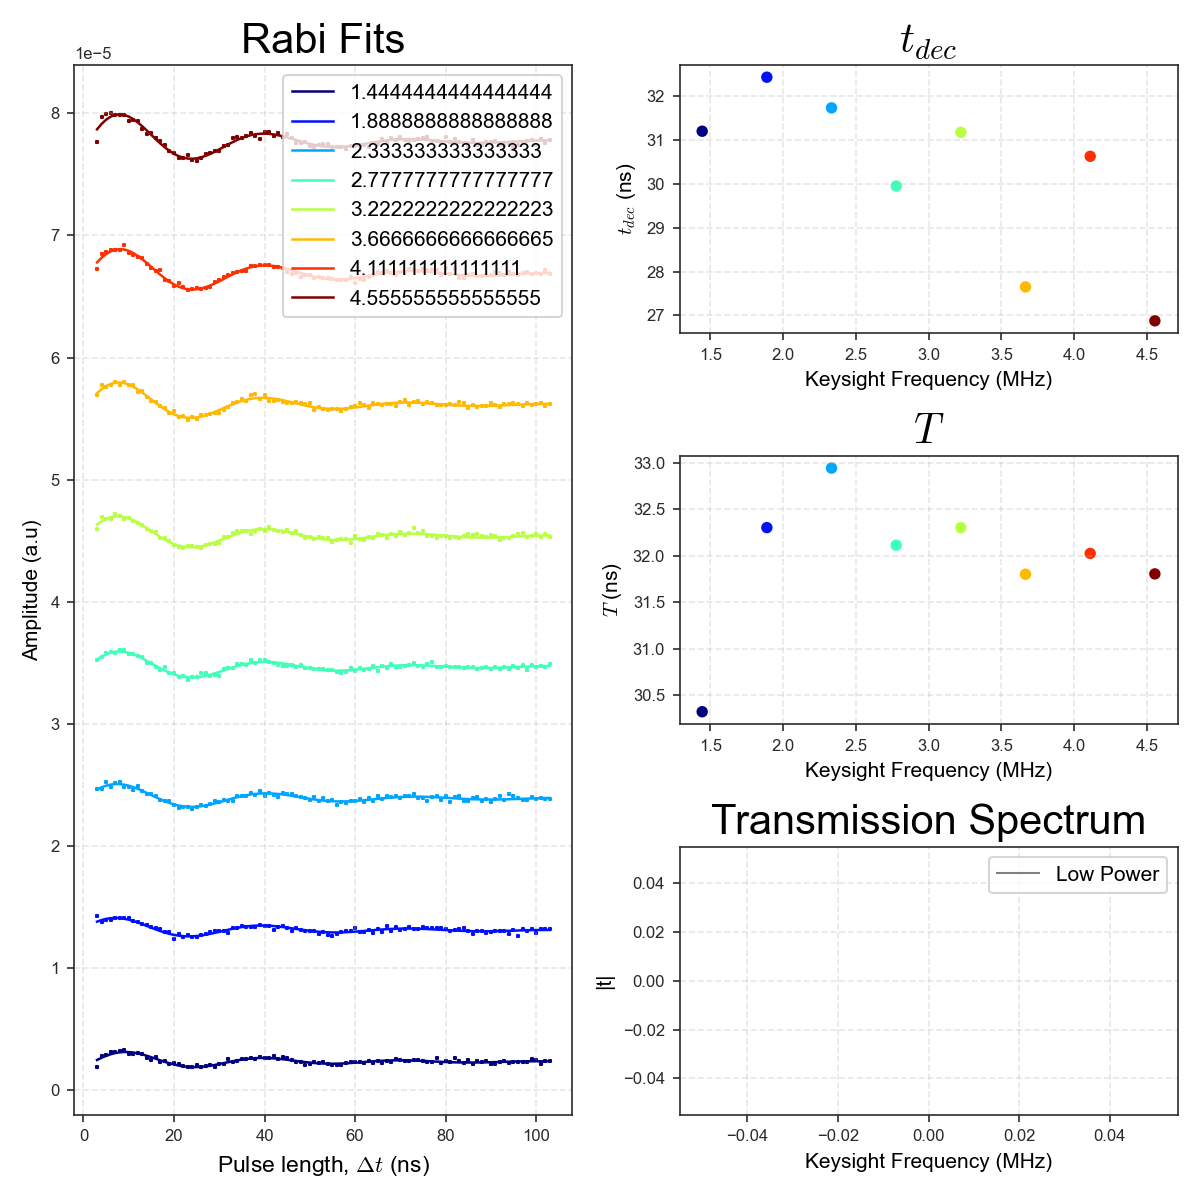

In [115]:
# Summarise the fittings:
SPACING = 0.00001
cmap = plt.cm.jet(np.linspace(0, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))
TRANSMISSION_FILE = "C:/ExperimentBlue/2021-08_photon-source/Ay_16_rabi-freq-sweep_vna-5dBm_transmission.txt"

# Plot T, t_dec for different frequencies and the rabi plots
# fix, ax = plt.subplots(3, 1, figsize=(4,9))
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 2)

ax0 = plt.subplot(gs[:, 0])
ax0.set_title("Rabi Fits")
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax0.set_ylabel("Amplitude (a.u)", fontsize=10)

ax1 = plt.subplot(gs[0, 1])
ax1.set_title("$t_{dec}$")
ax1.set_xlabel(f"{VARIABLE}", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=10)

ax2 = plt.subplot(gs[1, 1])
ax2.set_title("$T$")
ax2.set_xlabel(f"{VARIABLE}", fontsize=10)
ax2.set_ylabel("$T$ (ns)", fontsize=10)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model(T_DATA, *val), color=cmap[i], label=F_DATA[idx])
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap) 

# Plot transmission
ax3 = plt.subplot(gs[2, 1])
ax3.set_title("Transmission Spectrum")
ax3.set_xlabel(VARIABLE, fontsize=10)
ax3.set_ylabel("|t|", fontsize=10)


transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
ax3.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='gray', label="Low Power")
ax3.legend()

# ax32 = ax3.twinx() 
# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax32.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='black', label="Rabi Power")

# ax32.axvline(res_original)
# ax1.axvline(res_original)
# ax2.axvline(res_original)

# ax32.axvline(res_rabi)
# ax1.axvline(res_rabi)
# ax2.axvline(res_rabi)

# ax32.legend(loc='upper left')
# ax3.legend(loc='lower right')
ax0.legend()
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "svg"))
plt.savefig(FILENAME.replace("txt", "pdf"))

### Ay_21_rabi-bucket-width-sweep
Any bucket will do

In [116]:
RABI_MODEL = rabi_model
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_21_rabi-bucket-width-sweep.txt"
VARIABLE = "Bucket width (ns)"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f"data/cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

 c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py: 828

<IPython.core.display.Javascript object>


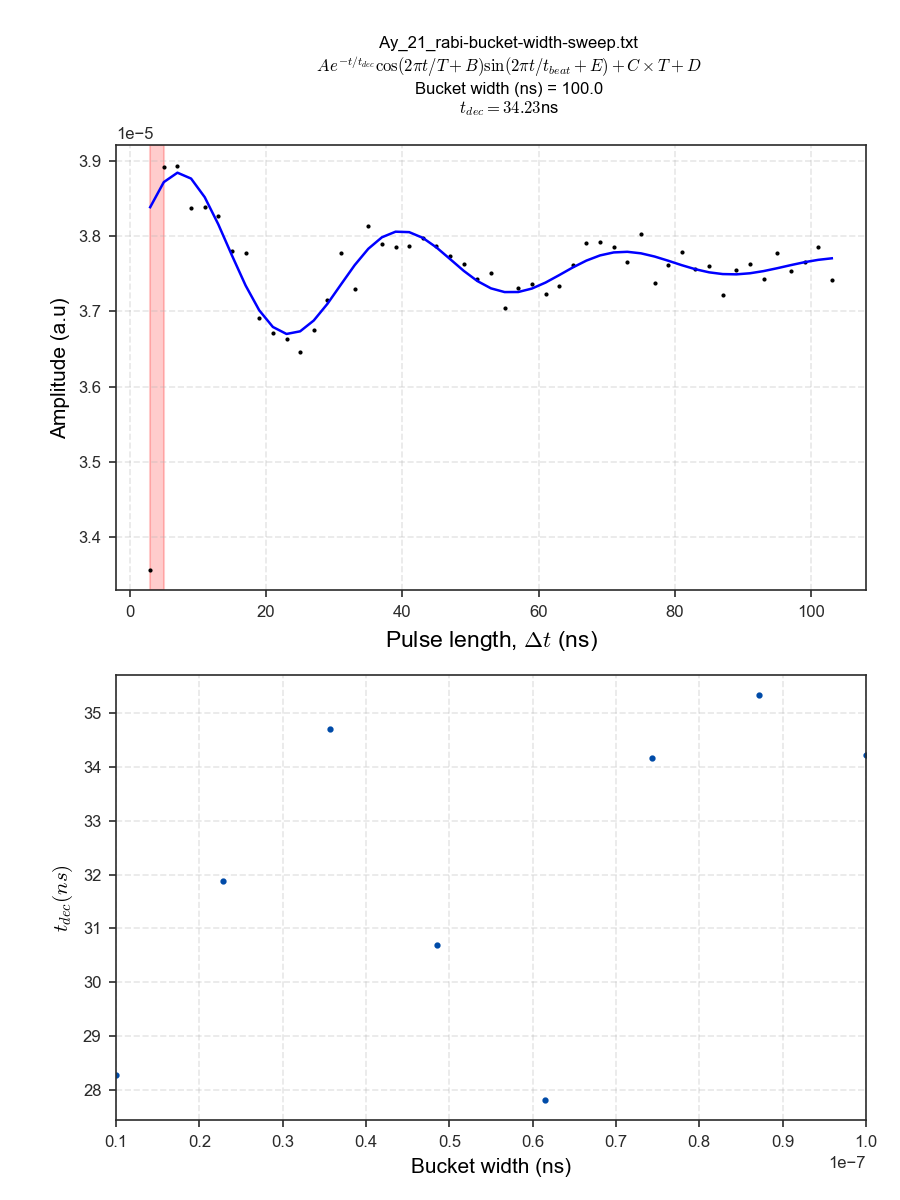

In [118]:
# Initial Guess
cut = (0, 1)
INDEX = 1
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    {VARIABLE} = {F_DATA[INDEX]}
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel(VARIABLE, fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        {VARIABLE} = {F_DATA[INDEX]}
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value/10**6, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f"data/cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

In [119]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[7, :] = INDEX_widget
ui[8, 0] = user_toggle_widget
ui[8, 1] = store_user_fit_widget
ui[8, 2] = fit_toggle_widget
ui[8, 3]= store_fit_widget
ui[9, :] = load_parameters_widget
ui[10, :] = dump_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

Stored parameters!{1: [18.491408253691194, 34.818602570597676, -3.837845011849065e-07, 4.563576637946515, 7.582987875672339e-10, 7.133911973427427e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [18.491408253691194, 34.818602570597676, -3.837845011849065e-07, 4.563576637946515, 7.582987875672339e-10, 7.133911973427427e-06, 1.5707963267948966, 8000.0]
Stored parameters!{1: [18.491408253691194, 34.818602570597676, -3.837845011849065e-07, 4.563576637946515, 7.58298787567234e-10, 7.133911973427427e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [18.491408253691194, 34.818602570597676, -3.837845011849065e-07, 4.563576637946515, 7.58298787567234e-10, 7.133911973427427e-06, 1.5707963267948966, 8000.0]
Stored parameters!{1: [18.491408253691194, 34.818602570597676, -3.837845011849065e-07, 4.563576637946515, 7.58298787567234e-10, 7.133911973427427e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [18.491408253691194, 34.818602570597676, -3.837845011849065e-07, 4.563576637946515, 

Loaded parameters!: [31.888569460323172, 33.01181571984109, 2.3383786321557362e-06, 0.06851582295593169, 6.115972099052952e-10, 7.146099016792353e-06, 4.371051456213499e-06, 1.5707963267948966]
Parameters saved to file: 'data/cache/Ay_21_rabi-bucket-width-sweep.txt.cache'
Stored parameters!{1: [31.888569460323172, 33.01181571984109, 2.3383786321557362e-06, 0.06851582295593169, 6.115972099052952e-10, 7.146099016792353e-06, 4.371051456213499e-06, 1.5707963267948966], 0: [28.266576809934772, 32.732649872472344, 2.0471784992645027e-06, -0.8536589314728124, -7.353892273156189e-11, 4.339453467461691e-06, 4.371051456213499e-06, 1.5707963267948966], 2: [34.70493508980851, 32.0999922737046, 1.5780134091922138e-06, 0.44448846522313856, 1.6768709164460143e-09, 1.275800178051396e-05, 4.371051456213499e-06, 1.5707963267948966]}
Loaded parameters!: [34.70493508980851, 32.0999922737046, 1.5780134091922138e-06, 0.44448846522313856, 1.6768709164460143e-09, 1.275800178051396e-05, 4.371051456213499e-06, 

Stored parameters!{1: [31.888569460323172, 33.01181571984109, 2.3383786321557362e-06, 0.06851582295593169, 6.115972099052952e-10, 7.146099016792353e-06, 4.371051456213499e-06, 1.5707963267948966], 0: [28.266576809934772, 32.732649872472344, 2.0471784992645027e-06, -0.8536589314728124, -7.353892273156189e-11, 4.339453467461691e-06, 4.371051456213499e-06, 1.5707963267948966], 2: [34.70538042838155, 32.10003412649145, 1.5780022255168094e-06, 0.4444947955642487, 1.6768393185947095e-09, 1.2758004104291867e-05, 4.371051456213499e-06, 1.5707963267948966], 3: [30.69601086906046, 31.846539303666233, 1.735334189562028e-06, -0.16399320824790498, 2.166975239674215e-09, 1.8172687067262267e-05, 4.371051456213499e-06, 1.5707963267948966], 4: [27.80930775943496, 33.22157409461603, 2.1150267430377715e-06, 0.15326978683800221, 2.2076814917058083e-09, 2.248570431606964e-05, 4.371051456213499e-06, 1.5707963267948966]}
Loaded parameters!: [27.80930775943496, 33.22157409461603, 2.1150267430377715e-06, 0.153

Loaded parameters!: [35.33417594278521, 32.497659599203736, 1.4714808440158967e-06, 0.0980811162830289, 2.1172471442589805e-09, 3.268601006045805e-05, 4.371051456213499e-06, 1.5707963267948966]
Stored parameters!{1: [31.888569460323172, 33.01181571984109, 2.3383786321557362e-06, 0.06851582295593169, 6.115972099052952e-10, 7.146099016792353e-06, 4.371051456213499e-06, 1.5707963267948966], 0: [28.266576809934772, 32.732649872472344, 2.0471784992645027e-06, -0.8536589314728124, -7.353892273156189e-11, 4.339453467461691e-06, 4.371051456213499e-06, 1.5707963267948966], 2: [34.70538042838155, 32.10003412649145, 1.5780022255168094e-06, 0.4444947955642487, 1.6768393185947095e-09, 1.2758004104291867e-05, 4.371051456213499e-06, 1.5707963267948966], 3: [30.69601086906046, 31.846539303666233, 1.735334189562028e-06, -0.16399320824790498, 2.166975239674215e-09, 1.8172687067262267e-05, 4.371051456213499e-06, 1.5707963267948966], 4: [27.809289843466185, 33.22174923308507, 2.1150260626832205e-06, 0.153

Loaded parameters!: [34.22766284607365, 32.59781830467169, 1.667332406271039e-06, 0.0386409378867027, 1.3342055589842904e-09, 3.7497666549043225e-05, 4.371051456213499e-06, 1.5707963267948966]
Parameters saved to file: 'data/cache/Ay_21_rabi-bucket-width-sweep.txt.cache'


<IPython.core.display.Javascript object>


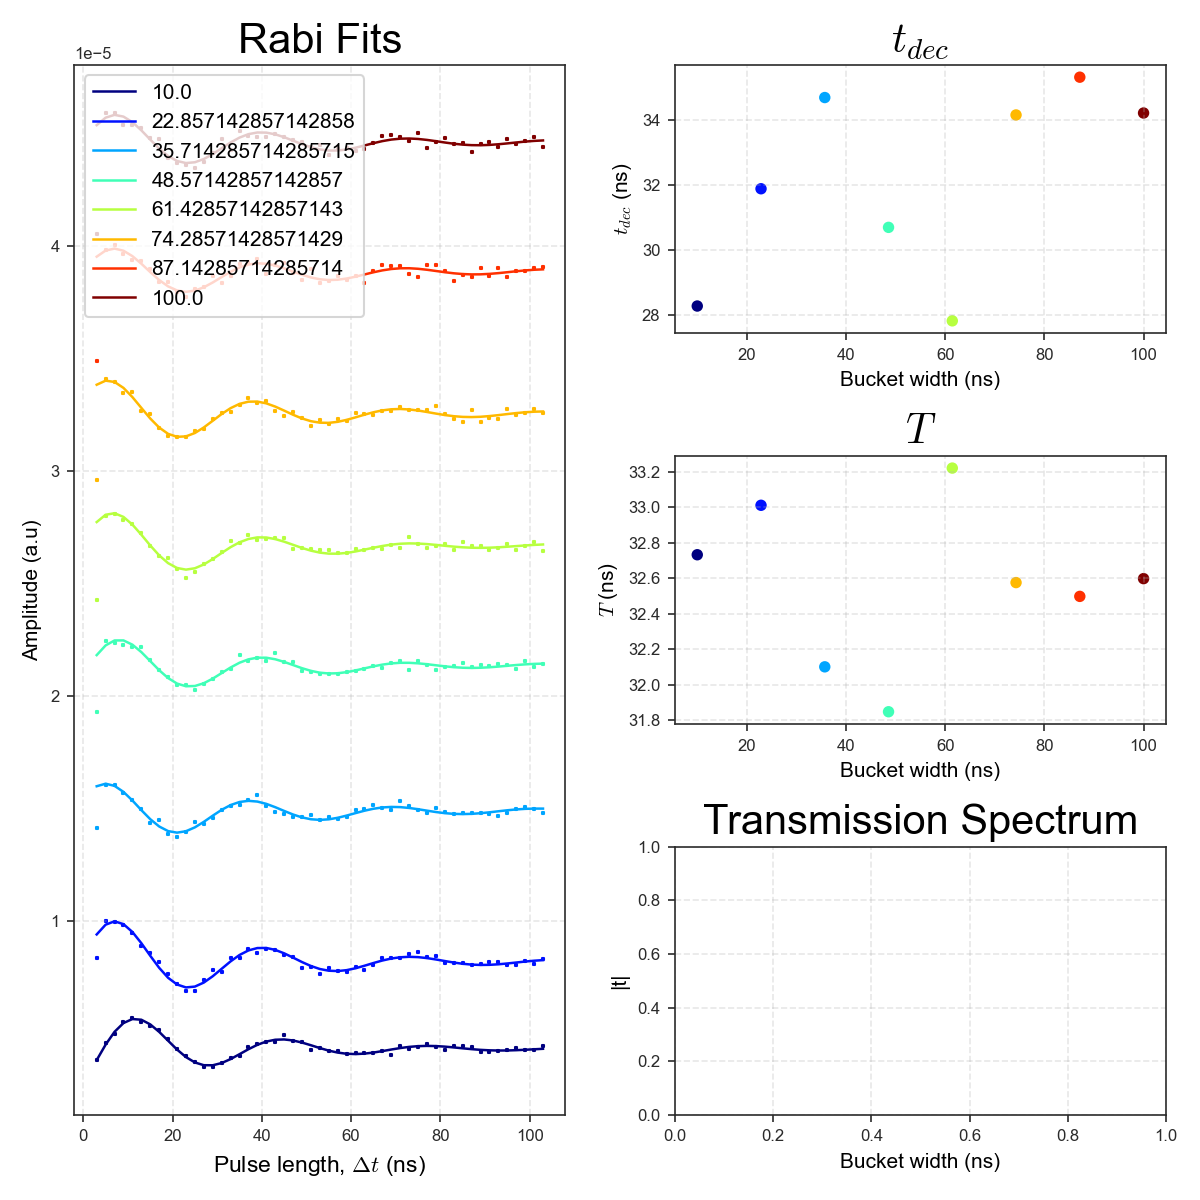

In [122]:
# Summarise the fittings:
SPACING = 0.000001
cmap = plt.cm.jet(np.linspace(0, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))
TRANSMISSION_FILE = "C:/ExperimentBlue/2021-08_photon-source/Ay_16_rabi-freq-sweep_vna-5dBm_transmission.txt"

# Plot T, t_dec for different frequencies and the rabi plots
# fix, ax = plt.subplots(3, 1, figsize=(4,9))
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 2)

ax0 = plt.subplot(gs[:, 0])
ax0.set_title("Rabi Fits")
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax0.set_ylabel("Amplitude (a.u)", fontsize=10)

ax1 = plt.subplot(gs[0, 1])
ax1.set_title("$t_{dec}$")
ax1.set_xlabel(f"{VARIABLE}", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=10)

ax2 = plt.subplot(gs[1, 1])
ax2.set_title("$T$")
ax2.set_xlabel(f"{VARIABLE}", fontsize=10)
ax2.set_ylabel("$T$ (ns)", fontsize=10)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model(T_DATA, *val), color=cmap[i], label=F_DATA[idx])
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap) 

# Plot transmission
ax3 = plt.subplot(gs[2, 1])
ax3.set_title("Transmission Spectrum")
ax3.set_xlabel(VARIABLE, fontsize=10)
ax3.set_ylabel("|t|", fontsize=10)


# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax3.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='gray', label="Low Power")
# ax3.legend()

# ax32 = ax3.twinx() 
# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax32.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='black', label="Rabi Power")

# ax32.axvline(res_original)
# ax1.axvline(res_original)
# ax2.axvline(res_original)

# ax32.axvline(res_rabi)
# ax1.axvline(res_rabi)
# ax2.axvline(res_rabi)

# ax32.legend(loc='upper left')
# ax3.legend(loc='lower right')
ax0.legend()
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "svg"))
plt.savefig(FILENAME.replace("txt", "pdf"))

# Rabi oscillations at zero magnetic field bias

### Ay_31_rabi-freq-sweep_vna5dBm

In [123]:
RABI_MODEL = rabi_model
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_31_rabi-freq-sweep_vna5dBm_5MHz.txt"
VARIABLE = "Keysight Frequency (MHz)"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f"data/cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

 c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py: 828

<IPython.core.display.Javascript object>


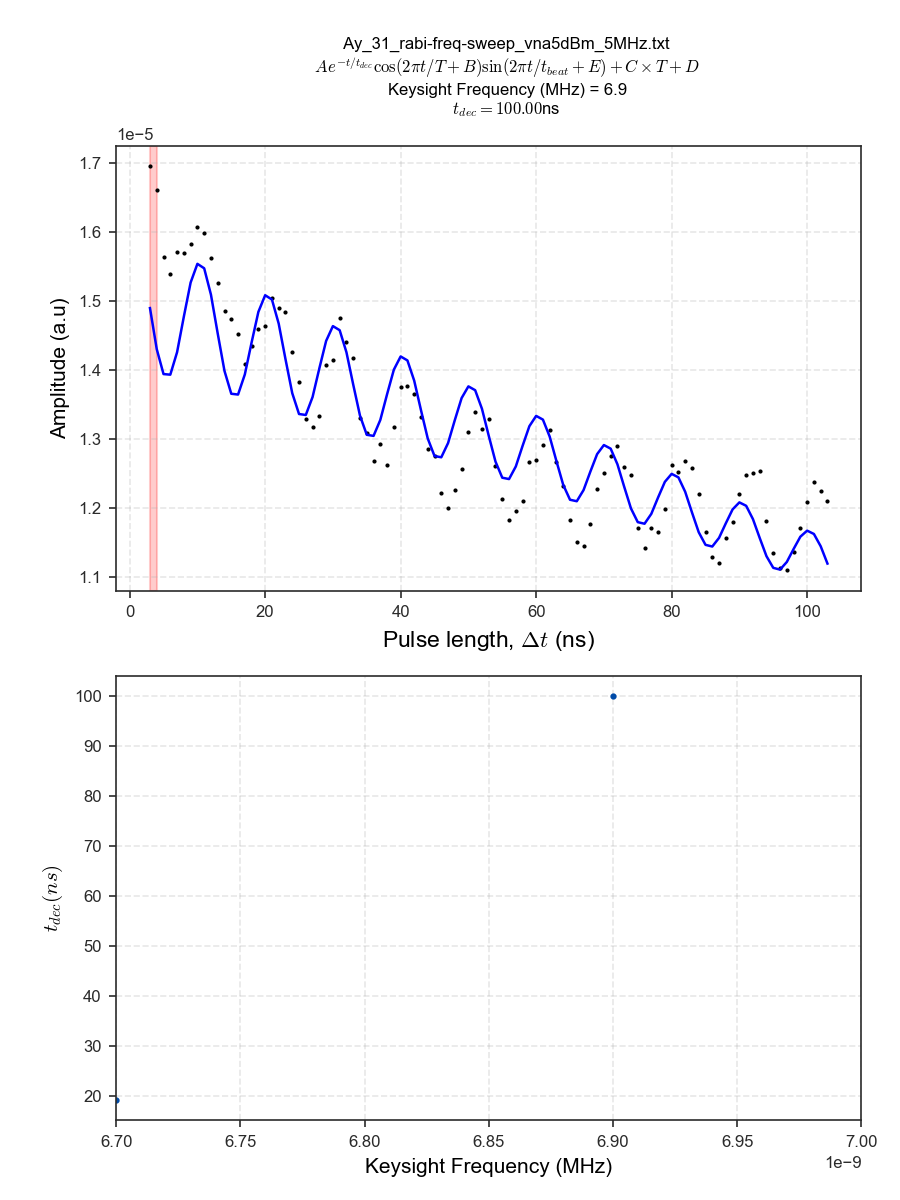

In [125]:
# Initial Guess
cut = (0, 1)
INDEX = 1
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    {VARIABLE} = {F_DATA[INDEX]}
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel(VARIABLE, fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        {VARIABLE} = {F_DATA[INDEX]}
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value/10**6, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f"data/cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

In [126]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[7, :] = INDEX_widget
ui[8, 0] = user_toggle_widget
ui[8, 1] = store_user_fit_widget
ui[8, 2] = fit_toggle_widget
ui[8, 3]= store_fit_widget
ui[9, :] = load_parameters_widget
ui[10, :] = dump_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

No parameters saved for this plot
Stored parameters!{0: [19.24360387398672, 35.363178732591216, 1.9521246349635818e-07, 4.497225630876573, 4.418293188463082e-09, 5.646793701292508e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [19.24360387398672, 35.363178732591216, 1.9521246349635818e-07, 4.497225630876573, 4.418293188463082e-09, 5.646793701292508e-06, 1.5707963267948966, 8000.0]
Stored parameters!{0: [19.24360387398672, 35.363178732591216, 1.9521246349635818e-07, 4.497225630876573, 4.418293188463082e-09, 5.646793701292508e-06, 1.5707963267948966, 8000.0], 20: [61.98828525345819, 184.33412873096356, 2.2959246538847327e-07, 23.770858216367273, -3.198222648603e-08, 1.4639290370700461e-05, 1.5707963267948966, 8000.0]}
Loaded parameters!: [61.98828525345819, 184.33412873096356, 2.2959246538847327e-07, 23.770858216367273, -3.198222648603e-08, 1.4639290370700461e-05, 1.5707963267948966, 8000.0]
Stored parameters!{0: [19.24360387398672, 35.363178732591216, 1.9521246349635818e-07, 4.49

<IPython.core.display.Javascript object>


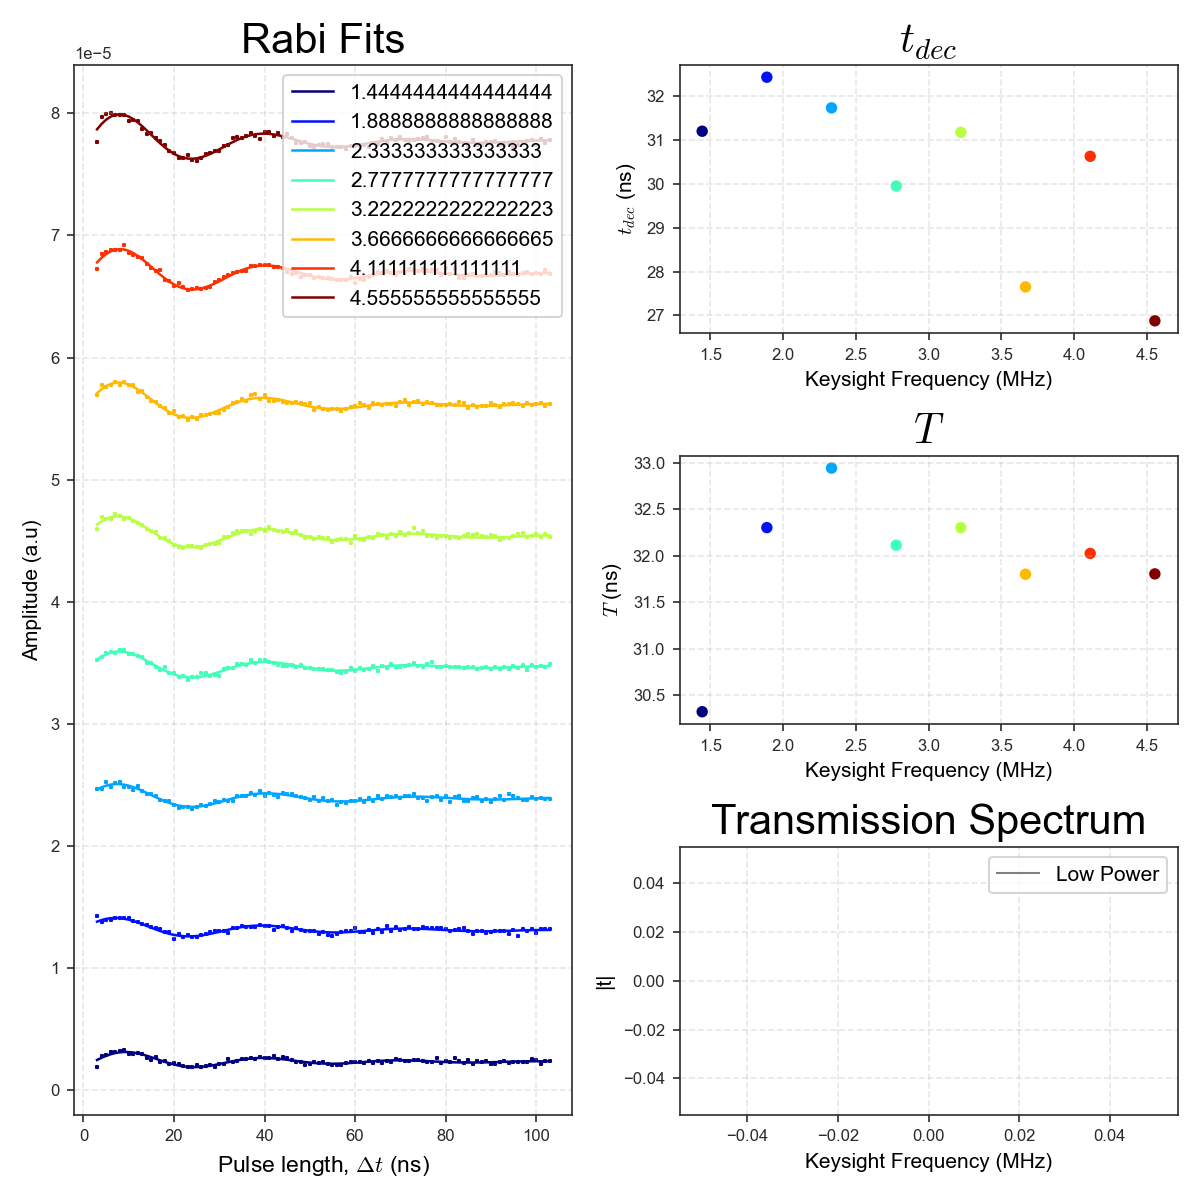

In [115]:
# Summarise the fittings:
SPACING = 0.00001
cmap = plt.cm.jet(np.linspace(0, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))
TRANSMISSION_FILE = "C:/ExperimentBlue/2021-08_photon-source/Ay_16_rabi-freq-sweep_vna-5dBm_transmission.txt"

# Plot T, t_dec for different frequencies and the rabi plots
# fix, ax = plt.subplots(3, 1, figsize=(4,9))
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 2)

ax0 = plt.subplot(gs[:, 0])
ax0.set_title("Rabi Fits")
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax0.set_ylabel("Amplitude (a.u)", fontsize=10)

ax1 = plt.subplot(gs[0, 1])
ax1.set_title("$t_{dec}$")
ax1.set_xlabel(f"{VARIABLE}", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=10)

ax2 = plt.subplot(gs[1, 1])
ax2.set_title("$T$")
ax2.set_xlabel(f"{VARIABLE}", fontsize=10)
ax2.set_ylabel("$T$ (ns)", fontsize=10)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model(T_DATA, *val), color=cmap[i], label=F_DATA[idx])
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap) 

# Plot transmission
ax3 = plt.subplot(gs[2, 1])
ax3.set_title("Transmission Spectrum")
ax3.set_xlabel(VARIABLE, fontsize=10)
ax3.set_ylabel("|t|", fontsize=10)


transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
ax3.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='gray', label="Low Power")
ax3.legend()

# ax32 = ax3.twinx() 
# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax32.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='black', label="Rabi Power")

# ax32.axvline(res_original)
# ax1.axvline(res_original)
# ax2.axvline(res_original)

# ax32.axvline(res_rabi)
# ax1.axvline(res_rabi)
# ax2.axvline(res_rabi)

# ax32.legend(loc='upper left')
# ax3.legend(loc='lower right')
ax0.legend()
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "svg"))
plt.savefig(FILENAME.replace("txt", "pdf"))

### Ay_34_rabi-freq-sweep_vna-10dBm
Best freq seems to be 6.915GHz

In [128]:
RABI_MODEL = rabi_model
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_34_rabi-freq-sweep_vna-10dBm.txt"
VARIABLE = "Frequency (GHz)"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f"data/cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

 c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py: 828

<IPython.core.display.Javascript object>


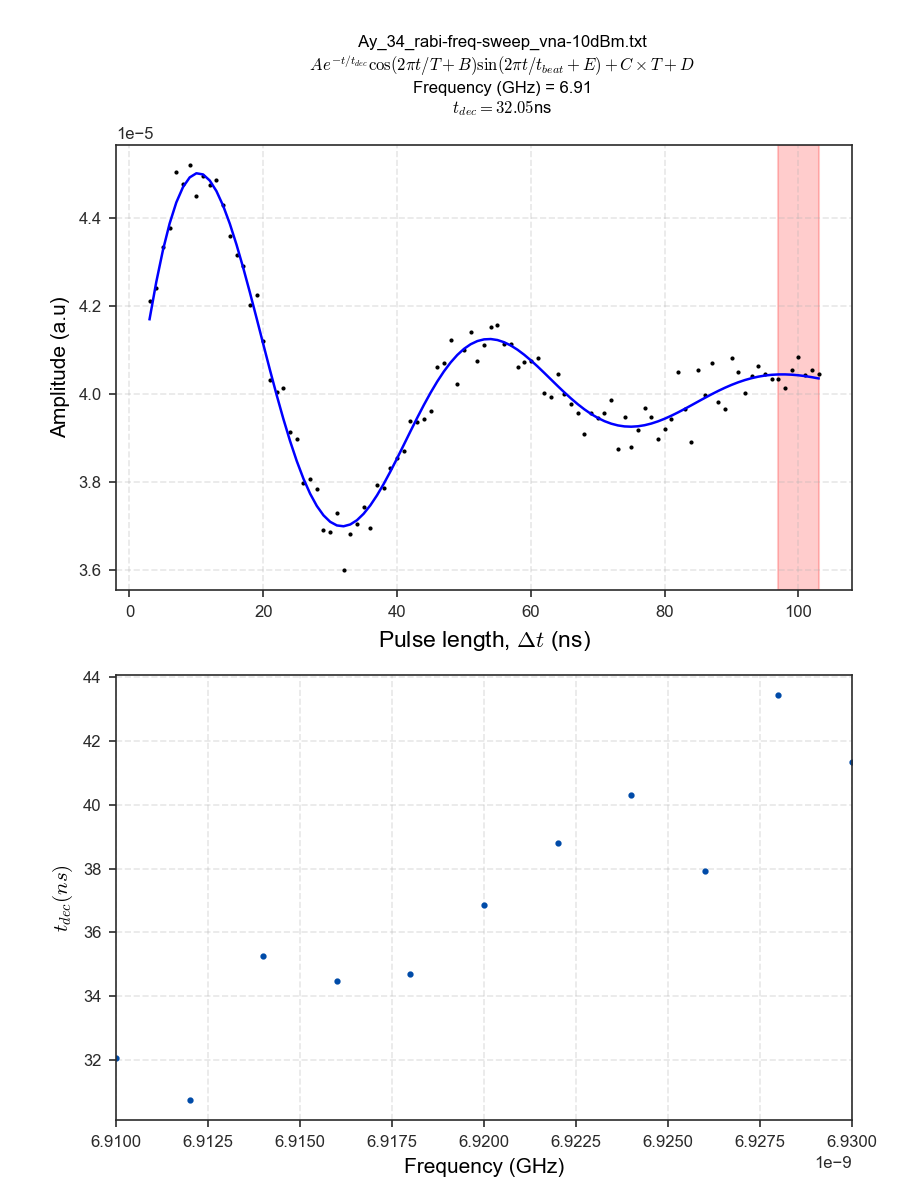

In [129]:
# Initial Guess
cut = (0, 1)
INDEX = 1
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel(VARIABLE, fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    {VARIABLE} = {F_DATA[INDEX]}
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel(VARIABLE, fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        {VARIABLE} = {F_DATA[INDEX]}
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value/10**6, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f"data/cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

In [130]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[7, :] = INDEX_widget
ui[8, 0] = user_toggle_widget
ui[8, 1] = store_user_fit_widget
ui[8, 2] = fit_toggle_widget
ui[8, 3]= store_fit_widget
ui[9, :] = load_parameters_widget
ui[10, :] = dump_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

Stored parameters!{8: [15.677149193351855, 39.51537842435156, -3.1199016602483213e-06, 4.9383284507128336, 9.358322235273466e-09, 1.3830383049076448e-05, 1.5707963267948966, 8000.0]}
Loaded parameters!: [15.677149193351855, 39.51537842435156, -3.1199016602483213e-06, 4.9383284507128336, 9.358322235273466e-09, 1.3830383049076448e-05, 1.5707963267948966, 8000.0]
Stored parameters!{8: [15.677149193351855, 39.51537842435156, -3.1199016602483213e-06, 4.9383284507128336, 9.358322235273466e-09, 1.3830383049076448e-05, 1.5707963267948966, 8000.0]}
Loaded parameters!: [15.677149193351855, 39.51537842435156, -3.1199016602483213e-06, 4.9383284507128336, 9.358322235273466e-09, 1.3830383049076448e-05, 1.5707963267948966, 8000.0]
Stored parameters!{8: [15.677149193351855, 39.51537842435156, -3.1199016602483213e-06, 4.9383284507128336, 9.358322235273466e-09, 1.3830383049076448e-05, 1.5707963267948966, 8000.0]}
Loaded parameters!: [15.677149193351855, 39.51537842435156, -3.1199016602483213e-06, 4.9383

Stored parameters!{8: [37.94195380703635, 29.001943836898125, 6.027568490784495e-06, 0.3280705656554843, 1.0861806617330636e-09, 1.440420630419201e-05, 1.5707963267948966, 8000.0], 9: [43.4347168950748, 27.284537361404066, 4.735912066531919e-06, 0.5720719774223519, 4.841480068530846e-10, 1.338949577343471e-05, 1.5707963267948966, 8000.0], 10: [41.35000355611065, 26.371187762029596, 4.005858011814608e-06, 0.8833920805594428, -3.5562555620647156e-09, 1.2656541106030504e-05, 1.5707963267948966, 8000.0]}
Loaded parameters!: [41.35000355611065, 26.371187762029596, 4.005858011814608e-06, 0.8833920805594428, -3.5562555620647156e-09, 1.2656541106030504e-05, 1.5707963267948966, 8000.0]
Stored parameters!{8: [37.94195380703635, 29.001943836898125, 6.027568490784495e-06, 0.3280705656554843, 1.0861806617330636e-09, 1.440420630419201e-05, 1.5707963267948966, 8000.0], 9: [43.4347168950748, 27.284537361404066, 4.735912066531919e-06, 0.5720719774223519, 4.841480068530846e-10, 1.338949577343471e-05, 1.

Loaded parameters!: [25.593114319292347, 32.49510098027925, 8.097774989476384e-06, -0.06115511302353721, 5.922120957635984e-09, 1.8248309381989268e-05, 1.5707963267948966, 8000.0]
Stored parameters!{8: [37.94195380703635, 29.001943836898125, 6.027568490784495e-06, 0.3280705656554843, 1.0861806617330636e-09, 1.440420630419201e-05, 1.5707963267948966, 8000.0], 9: [43.4347168950748, 27.284537361404066, 4.735912066531919e-06, 0.5720719774223519, 4.841480068530846e-10, 1.338949577343471e-05, 1.5707963267948966, 8000.0], 10: [41.33994848611866, 26.37538435318809, 4.00687043880898e-06, 0.8843355915952951, -3.5650969279294662e-09, 1.2657064842999506e-05, 1.5707963267948966, 8000.0], 7: [40.32123640947055, 30.82296251242399, 6.606151815398562e-06, 0.21225138048718456, -9.537541240708567e-11, 1.6177488658935183e-05, 1.5707963267948966, 8000.0], 6: [38.419100750744576, 33.517151012909295, 7.321627399056988e-06, 0.09519829513666068, 3.413691427824726e-09, 1.8393249196323063e-05, 1.5707963267948966

Loaded parameters!: [36.85882134366095, 34.672635718683615, 8.854353507026061e-06, -0.0951214271744173, 5.5293578244511795e-09, 2.1128130208711345e-05, 1.5707963267948966, 8000.0]
Stored parameters!{8: [37.94195380703635, 29.001943836898125, 6.027568490784495e-06, 0.3280705656554843, 1.0861806617330636e-09, 1.440420630419201e-05, 1.5707963267948966, 8000.0], 9: [43.4347168950748, 27.284537361404066, 4.735912066531919e-06, 0.5720719774223519, 4.841480068530846e-10, 1.338949577343471e-05, 1.5707963267948966, 8000.0], 10: [41.33994848611866, 26.37538435318809, 4.00687043880898e-06, 0.8843355915952951, -3.5650969279294662e-09, 1.2657064842999506e-05, 1.5707963267948966, 8000.0], 7: [40.32123640947055, 30.82296251242399, 6.606151815398562e-06, 0.21225138048718456, -9.537541240708567e-11, 1.6177488658935183e-05, 1.5707963267948966, 8000.0], 6: [38.80471414434024, 32.87286422288145, 7.910653797703834e-06, 0.025898696266697097, 4.697142154287496e-09, 1.831568038873916e-05, 1.5707963267948966, 

Loaded parameters!: [33.74385515954785, 38.63139438567773, 9.298440554787477e-06, -0.2787420144264148, -1.811895095043232e-09, 2.8430257477594215e-05, 1.5707963267948966, 8000.0]
Stored parameters!{8: [37.94195380703635, 29.001943836898125, 6.027568490784495e-06, 0.3280705656554843, 1.0861806617330636e-09, 1.440420630419201e-05, 1.5707963267948966, 8000.0], 9: [43.4347168950748, 27.284537361404066, 4.735912066531919e-06, 0.5720719774223519, 4.841480068530846e-10, 1.338949577343471e-05, 1.5707963267948966, 8000.0], 10: [41.33994848611866, 26.37538435318809, 4.00687043880898e-06, 0.8843355915952951, -3.5650969279294662e-09, 1.2657064842999506e-05, 1.5707963267948966, 8000.0], 7: [40.32123640947055, 30.82296251242399, 6.606151815398562e-06, 0.21225138048718456, -9.537541240708567e-11, 1.6177488658935183e-05, 1.5707963267948966, 8000.0], 6: [38.80471414434024, 32.87286422288145, 7.910653797703834e-06, 0.025898696266697097, 4.697142154287496e-09, 1.831568038873916e-05, 1.5707963267948966, 8

Loaded parameters!: [35.618690976901604, 39.99344593055485, 8.919384120530887e-06, -0.35614413709585807, 6.848972732656117e-10, 3.2676571592614396e-05, 1.5707963267948966, 8000.0]
Stored parameters!{8: [37.94195380703635, 29.001943836898125, 6.027568490784495e-06, 0.3280705656554843, 1.0861806617330636e-09, 1.440420630419201e-05, 1.5707963267948966, 8000.0], 9: [43.4347168950748, 27.284537361404066, 4.735912066531919e-06, 0.5720719774223519, 4.841480068530846e-10, 1.338949577343471e-05, 1.5707963267948966, 8000.0], 10: [41.33994848611866, 26.37538435318809, 4.00687043880898e-06, 0.8843355915952951, -3.5650969279294662e-09, 1.2657064842999506e-05, 1.5707963267948966, 8000.0], 7: [40.32123640947055, 30.82296251242399, 6.606151815398562e-06, 0.21225138048718456, -9.537541240708567e-11, 1.6177488658935183e-05, 1.5707963267948966, 8000.0], 6: [38.80471414434024, 32.87286422288145, 7.910653797703834e-06, 0.025898696266697097, 4.697142154287496e-09, 1.831568038873916e-05, 1.5707963267948966, 

Loaded parameters!: [30.77786268493671, 41.95724684484256, 8.909576669433595e-06, -0.2839771765119017, 5.834337885173835e-09, 3.6616807578689024e-05, 1.5707963267948966, 8000.0]
Stored parameters!{8: [37.94195380703635, 29.001943836898125, 6.027568490784495e-06, 0.3280705656554843, 1.0861806617330636e-09, 1.440420630419201e-05, 1.5707963267948966, 8000.0], 9: [43.4347168950748, 27.284537361404066, 4.735912066531919e-06, 0.5720719774223519, 4.841480068530846e-10, 1.338949577343471e-05, 1.5707963267948966, 8000.0], 10: [41.33994848611866, 26.37538435318809, 4.00687043880898e-06, 0.8843355915952951, -3.5650969279294662e-09, 1.2657064842999506e-05, 1.5707963267948966, 8000.0], 7: [40.32123640947055, 30.82296251242399, 6.606151815398562e-06, 0.21225138048718456, -9.537541240708567e-11, 1.6177488658935183e-05, 1.5707963267948966, 8000.0], 6: [38.80471414434024, 32.87286422288145, 7.910653797703834e-06, 0.025898696266697097, 4.697142154287496e-09, 1.831568038873916e-05, 1.5707963267948966, 80

Loaded parameters!: [32.05791274610607, 43.32989563364269, 7.600178597834053e-06, -0.12467418292754995, 5.311190079106631e-09, 3.9558195554932006e-05, 1.5707963267948966, 8000.0]
Stored parameters!{8: [37.94195380703635, 29.001943836898125, 6.027568490784495e-06, 0.3280705656554843, 1.0861806617330636e-09, 1.440420630419201e-05, 1.5707963267948966, 8000.0], 9: [43.4347168950748, 27.284537361404066, 4.735912066531919e-06, 0.5720719774223519, 4.841480068530846e-10, 1.338949577343471e-05, 1.5707963267948966, 8000.0], 10: [41.33994848611866, 26.37538435318809, 4.00687043880898e-06, 0.8843355915952951, -3.5650969279294662e-09, 1.2657064842999506e-05, 1.5707963267948966, 8000.0], 7: [40.32123640947055, 30.82296251242399, 6.606151815398562e-06, 0.21225138048718456, -9.537541240708567e-11, 1.6177488658935183e-05, 1.5707963267948966, 8000.0], 6: [38.80471414434024, 32.87286422288145, 7.910653797703834e-06, 0.025898696266697097, 4.697142154287496e-09, 1.831568038873916e-05, 1.5707963267948966, 8

<IPython.core.display.Javascript object>


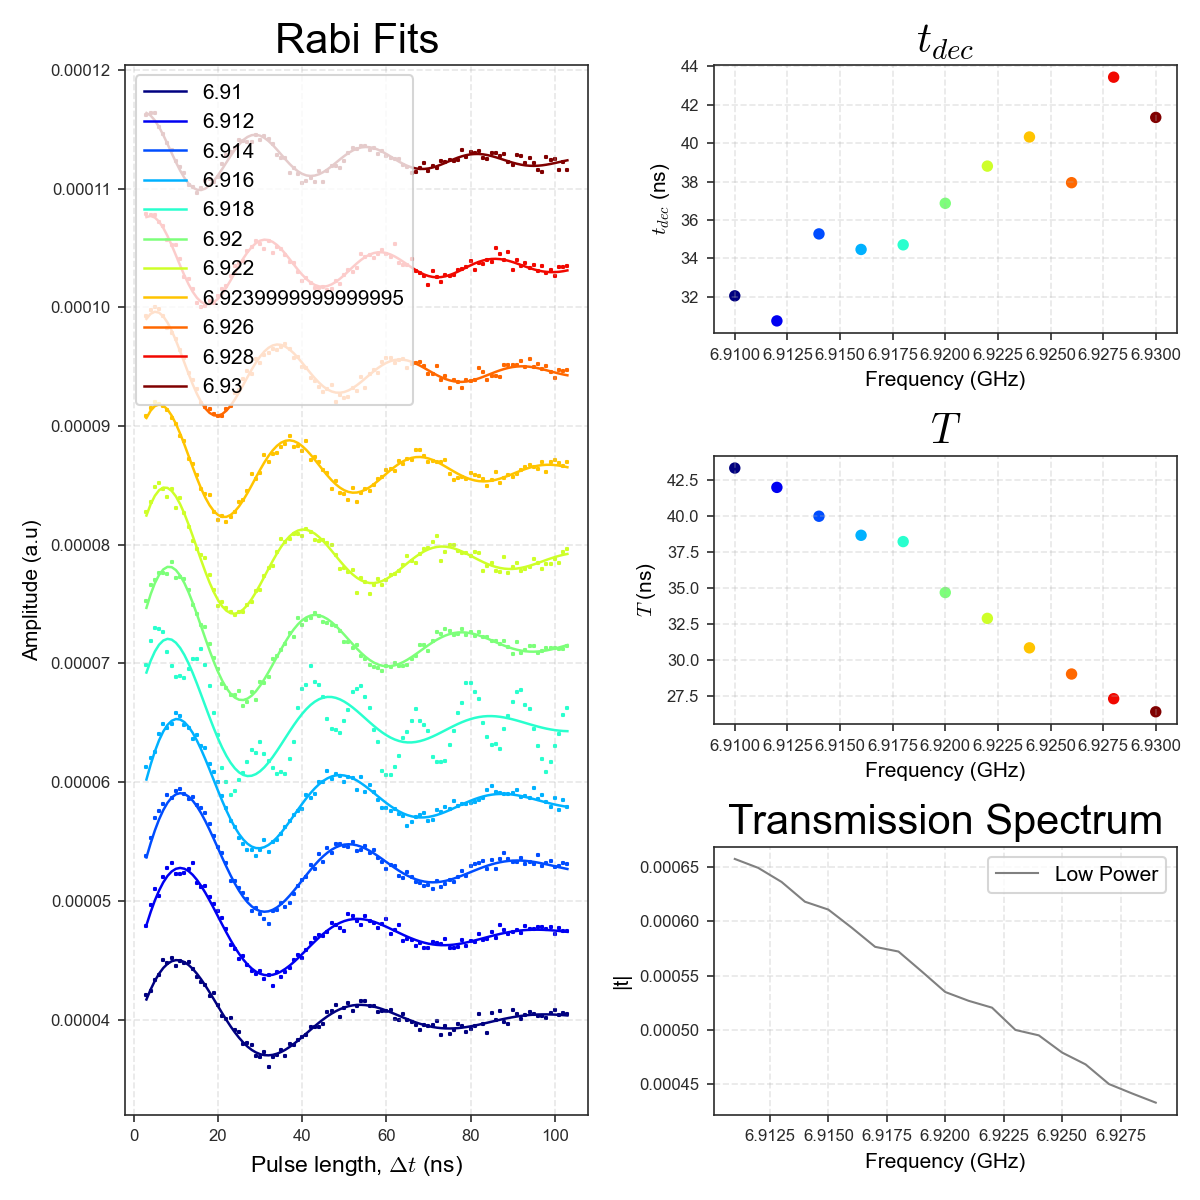

In [131]:
# Summarise the fittings:
SPACING = 0.00001
cmap = plt.cm.jet(np.linspace(0, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))
TRANSMISSION_FILE = "C:/ExperimentBlue/2021-08_photon-source/Ay_34_rabi-freq-sweep_vna-10dBm_transmission.txt"

# Plot T, t_dec for different frequencies and the rabi plots
# fix, ax = plt.subplots(3, 1, figsize=(4,9))
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 2)

ax0 = plt.subplot(gs[:, 0])
ax0.set_title("Rabi Fits")
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax0.set_ylabel("Amplitude (a.u)", fontsize=10)

ax1 = plt.subplot(gs[0, 1])
ax1.set_title("$t_{dec}$")
ax1.set_xlabel(f"{VARIABLE}", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=10)

ax2 = plt.subplot(gs[1, 1])
ax2.set_title("$T$")
ax2.set_xlabel(f"{VARIABLE}", fontsize=10)
ax2.set_ylabel("$T$ (ns)", fontsize=10)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model(T_DATA, *val), color=cmap[i], label=F_DATA[idx])
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap) 

# Plot transmission
ax3 = plt.subplot(gs[2, 1])
ax3.set_title("Transmission Spectrum")
ax3.set_xlabel(VARIABLE, fontsize=10)
ax3.set_ylabel("|t|", fontsize=10)


transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
ax3.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='gray', label="Low Power")
ax3.legend()

# ax32 = ax3.twinx() 
# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax32.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='black', label="Rabi Power")

# ax32.axvline(res_original)
# ax1.axvline(res_original)
# ax2.axvline(res_original)

# ax32.axvline(res_rabi)
# ax1.axvline(res_rabi)
# ax2.axvline(res_rabi)

# ax32.legend(loc='upper left')
# ax3.legend(loc='lower right')
ax0.legend()
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "svg"))
plt.savefig(FILENAME.replace("txt", "pdf"))

### Ay_35_rabi-power-sweep_vna-10dBm
-2dBm to -10dBm are all good values to use

In [133]:
RABI_MODEL = rabi_model
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_35_rabi-power-sweep_vna-10dBm.txt"
VARIABLE = "Power (dBm)"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f"data/cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

 c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py: 828

<IPython.core.display.Javascript object>


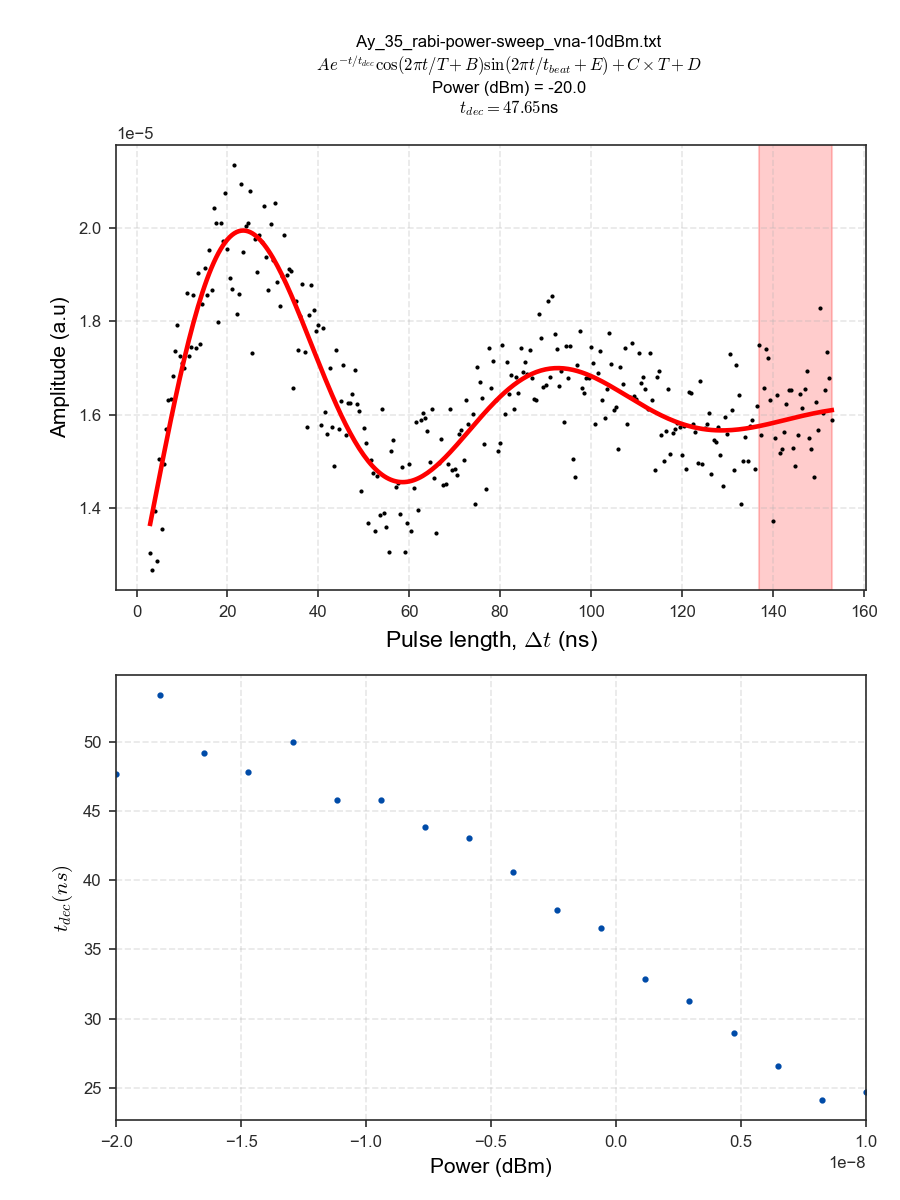

In [134]:
# Initial Guess
cut = (0, 1)
INDEX = 1
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    {VARIABLE} = {F_DATA[INDEX]}
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel(VARIABLE, fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        {VARIABLE} = {F_DATA[INDEX]}
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value/10**6, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f"data/cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

In [135]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[7, :] = INDEX_widget
ui[8, 0] = user_toggle_widget
ui[8, 1] = store_user_fit_widget
ui[8, 2] = fit_toggle_widget
ui[8, 3]= store_fit_widget
ui[9, :] = load_parameters_widget
ui[10, :] = dump_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

Stored parameters!{17: [4.896245215354181, 38.19578846282436, -1.5256849304424233e-06, 4.979661326917974, -9.874533702196908e-10, 3.5178888437821503e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [4.896245215354181, 38.19578846282436, -1.5256849304424233e-06, 4.979661326917974, -9.874533702196908e-10, 3.5178888437821503e-06, 1.5707963267948966, 8000.0]
Stored parameters!{17: [4.896245215354181, 38.19578846282436, -1.5256849304424233e-06, 4.979661326917974, -9.874533702196908e-10, 3.5178888437821503e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [4.896245215354181, 38.19578846282436, -1.5256849304424233e-06, 4.979661326917974, -9.874533702196908e-10, 3.5178888437821503e-06, 1.5707963267948966, 8000.0]
Stored parameters!{17: [4.896245215354181, 38.19578846282436, -1.5256849304424233e-06, 4.979661326917974, -9.874533702196908e-10, 3.5178888437821503e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [4.896245215354181, 38.19578846282436, -1.5256849304424233e-06, 4.9796613

 <ipython-input-36-cb014b7bd86b>: 90

Loaded parameters!: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0]}


 <ipython-input-36-cb014b7bd86b>: 90

Loaded parameters!: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 4e-06, 1.5707963267948966, 8000.0]}


 <ipython-input-36-cb014b7bd86b>: 90

Loaded parameters!: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 4e-06, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 4e-06, 1.5707963267948966, 8000.0]}


 <ipython-input-36-cb014b7bd86b>: 90

Loaded parameters!: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 4e-06, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [21.19607090306669, 19.97079113390324, 1.860343876590911e-06, 0.33924922414291436, -4.839866611929166e-10, 4.304474799059057e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [21.19607090306669, 19.97079113390324, 1.860343876590911e-06, 0.33924922414291436, -4.839866611929166e-10, 4.304474799059057e-06, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [10.9343433203273, 18.402751046484344, 2.2017935165000633e-06, 0.43651471324121827, -1.7373899725710275e-10, 4.2775865

Loaded parameters!: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0]
Parameters saved to file: 'data/cache/Ay_35_rabi-power-sweep_vna-10dBm.txt.cache'
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15

Loaded parameters!: [26.582834237313733, 21.43914766472131, 2.0096313947444166e-06, 0.2690376842842637, 6.613888710025287e-11, 5.31953915822252e-06, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582828412199422, 21.439134059058695, 2.0096315192538595e-06, 0.26903428186251205, 6.614285808976441e-11, 5.3195388063029845e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [26.582828412199422, 21.439134059058695, 2.0096315192538595e-06, 0.26903428186251205, 6.614285808976441e-11, 5.3195388063029845e-06, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.26799865479512

Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574

Loaded parameters!: [31.28036447573313, 30.878780063827644, 2.680676801301012e-06, -0.029748612759855537, 3.347209861801093e-10, 7.574691657047161e-06, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281990256138336, 30.87816384697581, 2.6808132765731526e-06, -0.029843245701536306, 3.350496349420075e-10, 7.574668496275401e-06, 1.5707963

Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.5707963267948966, 8000.0], 12: [23.220543772729748, 35.34459028346287, 3.3626221820325515e-06, -0.15686649982624573, 4.6179582260105846e-10, 8.755647889047631e-06, 1.5707963267948966, 800

Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.5707963267948966, 8000.0], 12: [32.900538514335295, 36.274154532145324, 3.0795759882388555e-06, -0.15293817384592112, 6.093434239923061e-12, 8.788977485071915e-06, 1.5707963267948966, 800

Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.5707963267948966, 8000.0], 12: [32.90067142061582, 36.27413251390726, 3.0795730310586577e-06, -0.15293717171520782, 6.025106440268031e-12, 8.788981510424353e-06, 1.5707963267948966, 8000.

Loaded parameters!: [36.97220165477232, 42.6429165357166, 3.392056332180537e-06, -0.27142690548012643, 1.985995724603107e-10, 1.019371612426057e-05, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.5707963267

Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.5707963267948966, 8000.0], 12: [32.90067142061582, 36.27413251390726, 3.0795730310586577e-06, -0.15293717171520782, 6.025106440268031e-12, 8.788981510424353e-06, 1.5707963267948966, 8000.

Loaded parameters!: [13.881486892118254, 45.721053499230706, 4.181490066212524e-06, 0.0, 9.856032593841527e-10, 1.1362321562758865e-05, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.5707963267948966, 8000.

Loaded parameters!: [37.78059851742948, 48.26502452479463, 3.7695772151346527e-06, -0.4192546654853499, 5.024494303465774e-10, 1.1397538167629143e-05, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.57079632

Loaded parameters!: [37.85246713947172, 48.23408206502216, 3.770643817826015e-06, -0.419402536701567, 5.039309703492741e-10, 1.1397393672024283e-05, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.5707963267

Loaded parameters!: [40.61011590084303, 53.114700508185415, 4.249906203761699e-06, 5.783343802518212, -6.792067572030175e-12, 1.252919005212672e-05, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.5707963267

Loaded parameters!: [34.83386381954481, 57.66467580313169, 5.165424730074196e-06, 5.6713518960714415, -4.771722318597768e-10, 1.3602803543236967e-05, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.570796326

Loaded parameters!: [43.05301566993655, 57.61059196670907, 4.938876945910428e-06, 5.684785685620457, -3.5166920158991547e-10, 1.360157450949301e-05, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.5707963267

Loaded parameters!: [43.83898017337379, 61.1893204374888, 5.528581454068733e-06, 5.63049993741028, -6.6605747054816e-10, 1.4365144342067603e-05, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.57079632679489

Loaded parameters!: [45.77041985162162, 64.07657949513167, 5.811458599425215e-06, 5.59958567614107, -7.118132355328523e-10, 1.4911147033922955e-05, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.57079632679

Loaded parameters!: [45.83666431574686, 66.94984055002828, 6.2367721082937165e-06, 5.597184552035404, 4.873832509453031e-10, 1.528212402320712e-05, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.57079632679

Loaded parameters!: [49.94435911944027, 67.79499971740626, 6.024471016605779e-06, 5.548215316633632, -1.7913022999162148e-09, 1.5746304351204027e-05, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.570796326

Loaded parameters!: [47.53004782095308, 68.68838468527542, 6.371409006514414e-06, 5.501208088691525, -1.3885215577733377e-09, 1.5875605063676103e-05, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.570796326

Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.5707963267948966, 8000.0], 12: [32.90067142061582, 36.27413251390726, 3.0795730310586577e-06, -0.15293717171520782, 6.025106440268031e-12, 8.788981510424353e-06, 1.5707963267948966, 8000.

Loaded parameters!: [49.154167120318, 69.8182118291088, 6.259158545580467e-06, 5.562150749600734, -4.118825891877071e-09, 1.6350169919438865e-05, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.5707963267948

Loaded parameters!: [53.48581388321947, 69.27106544288223, 6.007847946427248e-06, 5.48609286887784, -1.861877514936963e-09, 1.6357971114502323e-05, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.57079632679

Loaded parameters!: [53.34323647736212, 69.19536063437602, 6.058432681376516e-06, 5.483316097824566, -1.82783410621233e-09, 1.6355299513927625e-05, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.57079632679

Loaded parameters!: [47.67641273631455, 69.55768856828472, 5.9979319163261805e-06, 5.4965547601585465, -3.025845334272487e-09, 1.6450170316930186e-05, 1.5707963267948966, 8000.0]
Stored parameters!{17: [24.696450681434133, 15.343025270308505, 1.5404024048325012e-06, 0.13380781735534264, -4.267998654795126e-10, 3.4442695790574115e-06, 1.5707963267948966, 8000.0], 16: [24.139184523652144, 17.702658934896277, 1.8195642012853863e-06, 0.2275048978762506, -2.33451077249581e-10, 4.280803128610828e-06, 1.5707963267948966, 8000.0], 15: [26.582830041236402, 21.43913305558593, 2.009631480058023e-06, 0.2690340075668691, 6.61453095154512e-11, 5.319538658021908e-06, 1.5707963267948966, 8000.0], 14: [28.989632529671233, 26.26957499520474, 2.3224850003753834e-06, 0.1591367795054105, 5.174508458994588e-10, 6.447502711663877e-06, 1.5707963267948966, 8000.0], 13: [31.281947542047163, 30.87815433845555, 2.6808094315184086e-06, -0.029841868513975165, 3.350412550644249e-10, 7.574669086825805e-06, 1.57079632

<IPython.core.display.Javascript object>


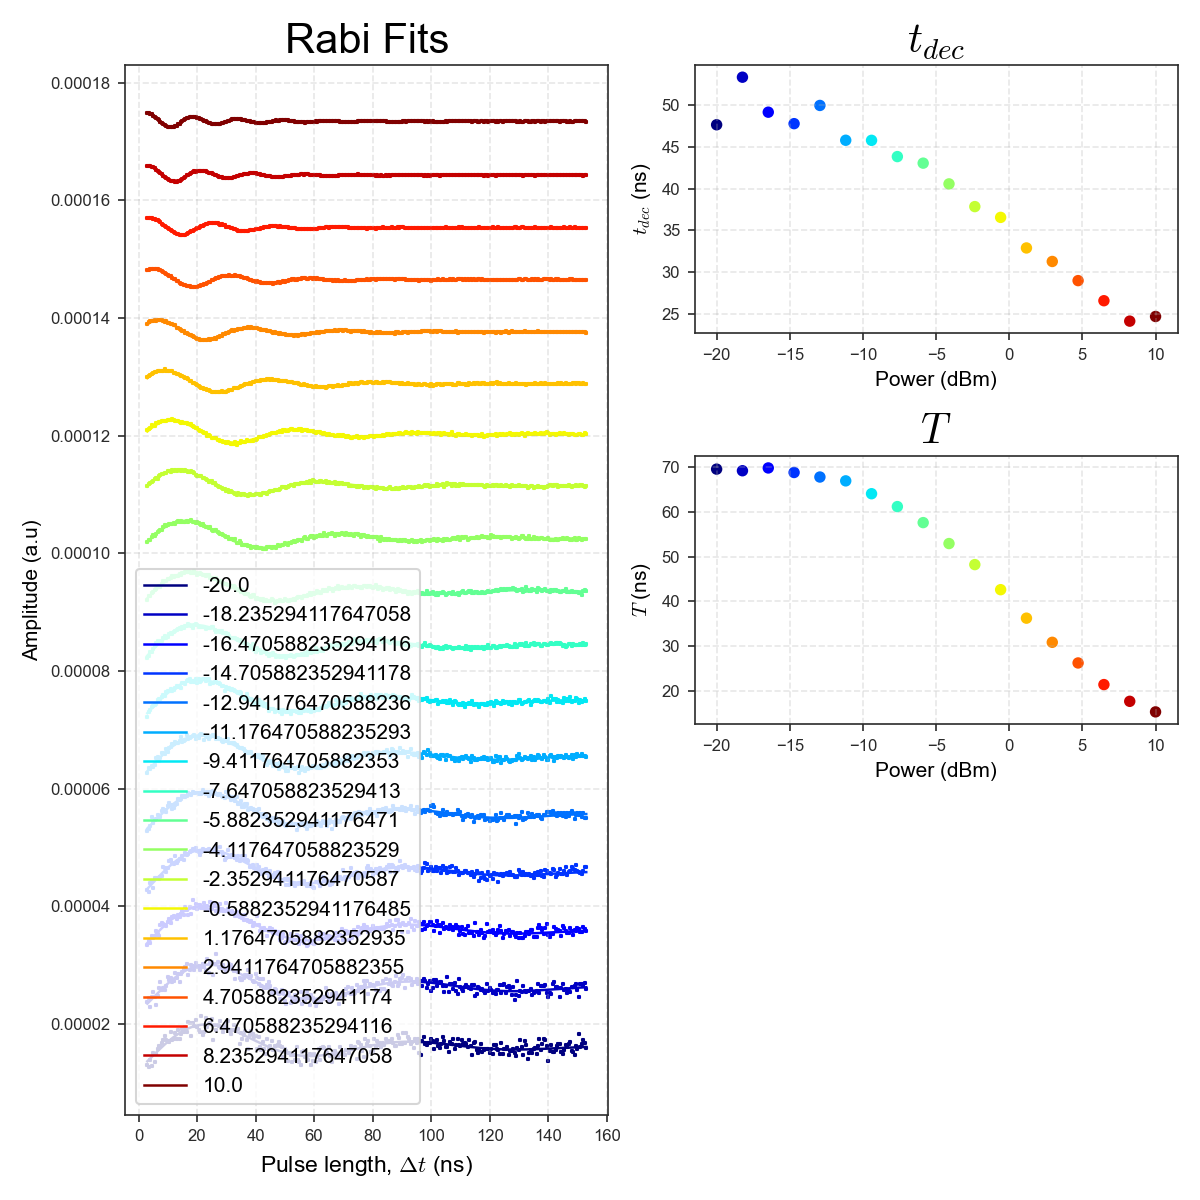

In [136]:
# Summarise the fittings:
SPACING = 0.00001
cmap = plt.cm.jet(np.linspace(0, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))
TRANSMISSION_FILE = "C:/ExperimentBlue/2021-08_photon-source/Ay_16_rabi-freq-sweep_vna-5dBm_transmission.txt"

# Plot T, t_dec for different frequencies and the rabi plots
# fix, ax = plt.subplots(3, 1, figsize=(4,9))
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 2)

ax0 = plt.subplot(gs[:, 0])
ax0.set_title("Rabi Fits")
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax0.set_ylabel("Amplitude (a.u)", fontsize=10)

ax1 = plt.subplot(gs[0, 1])
ax1.set_title("$t_{dec}$")
ax1.set_xlabel(f"{VARIABLE}", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=10)

ax2 = plt.subplot(gs[1, 1])
ax2.set_title("$T$")
ax2.set_xlabel(f"{VARIABLE}", fontsize=10)
ax2.set_ylabel("$T$ (ns)", fontsize=10)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model(T_DATA, *val), color=cmap[i], label=F_DATA[idx])
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap) 

# Plot transmission
# ax3 = plt.subplot(gs[2, 1])
# ax3.set_title("Transmission Spectrum")
# ax3.set_xlabel(VARIABLE, fontsize=10)
# ax3.set_ylabel("|t|", fontsize=10)


# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax3.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='gray', label="Low Power")
# ax3.legend()

# ax32 = ax3.twinx() 
# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax32.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='black', label="Rabi Power")

# ax32.axvline(res_original)
# ax1.axvline(res_original)
# ax2.axvline(res_original)

# ax32.axvline(res_rabi)
# ax1.axvline(res_rabi)
# ax2.axvline(res_rabi)

# ax32.legend(loc='upper left')
# ax3.legend(loc='lower right')
ax0.legend()
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "svg"))
plt.savefig(FILENAME.replace("txt", "pdf"))

### Ay_36_rabi-keysight-sweep_vna-10dBm
Use Keysight Frequnecy of 4MHz

In [140]:
RABI_MODEL = rabi_model
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_36_rabi-keysight-sweep_vna-10dBm.txt"
VARIABLE = "Keysight Frequency (MHz)"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f"data/cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

<IPython.core.display.Javascript object>


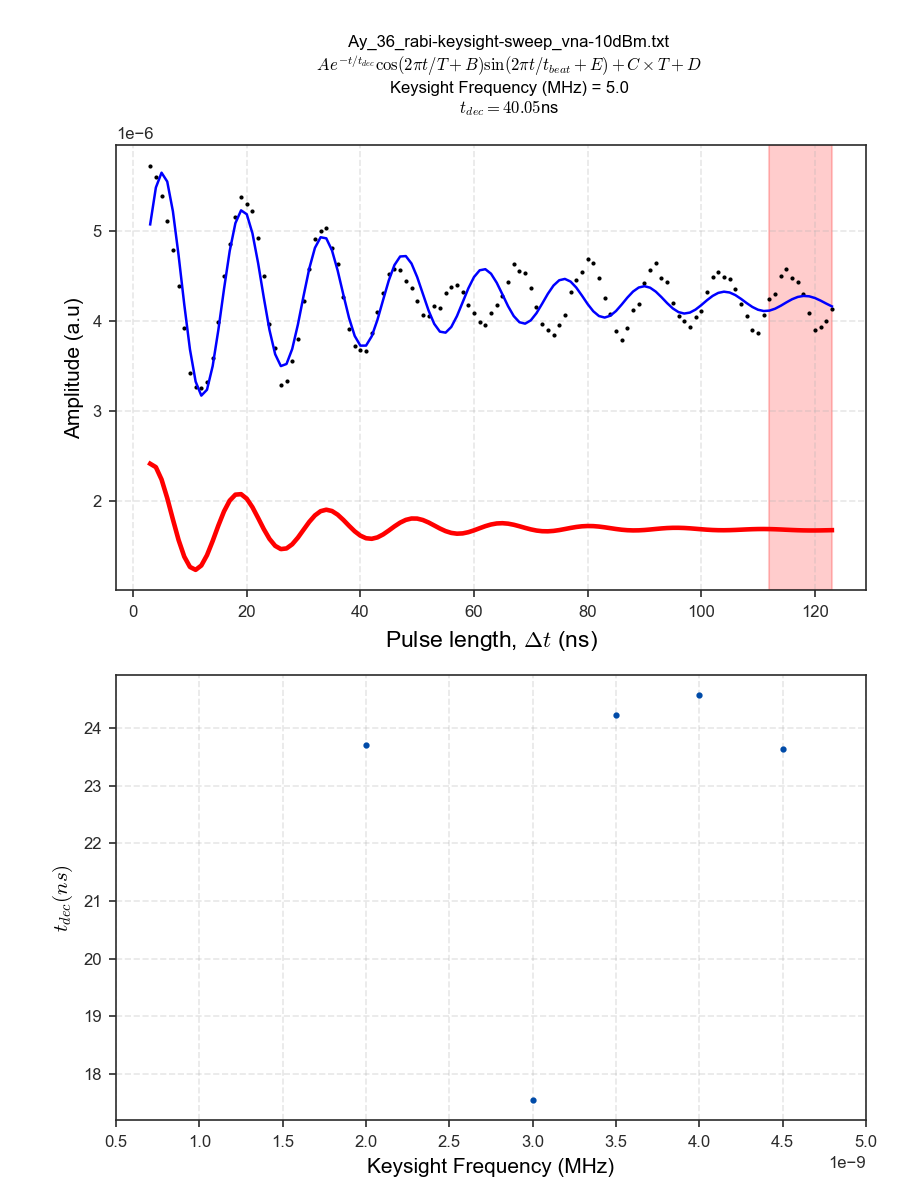

In [141]:
# Initial Guess
cut = (0, 1)
INDEX = 1
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    {VARIABLE} = {F_DATA[INDEX]}
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel(VARIABLE, fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        {VARIABLE} = {F_DATA[INDEX]}
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value/10**6, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f"data/cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

In [142]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[7, :] = INDEX_widget
ui[8, 0] = user_toggle_widget
ui[8, 1] = store_user_fit_widget
ui[8, 2] = fit_toggle_widget
ui[8, 3]= store_fit_widget
ui[9, :] = load_parameters_widget
ui[10, :] = dump_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

Stored parameters!{8: [5.311222565629187, 38.46551881967207, -1.6345289610076043e-06, 4.991289937601263, -1.7619633914748196e-09, 3.982228150707833e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [5.311222565629187, 38.46551881967207, -1.6345289610076043e-06, 4.991289937601263, -1.7619633914748196e-09, 3.982228150707833e-06, 1.5707963267948966, 8000.0]
Stored parameters!{8: [5.311222565629187, 38.46551881967207, -1.6345289610076043e-06, 4.991289937601263, -1.7619633914748196e-09, 3.982228150707833e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [5.311222565629187, 38.46551881967207, -1.6345289610076043e-06, 4.991289937601263, -1.7619633914748196e-09, 3.982228150707833e-06, 1.5707963267948966, 8000.0]
Stored parameters!{8: [16.783202115693776, 39.26571260791453, 9.302476046904976e-07, 1.7298843626960876, -2.31527228060811e-09, 4.008129697756262e-06, 1.5707963267948966, 8000.0]}
Loaded parameters!: [16.783202115693776, 39.26571260791453, 9.302476046904976e-07, 1.7298843626960

Loaded parameters!: [17.55308739062417, 15.358128731701528, 1.532288114484167e-06, 0.2258284036380087, -3.243347423429489e-10, 2.5943694838448654e-06, 1.5707963267948966, 8000.0]
Stored parameters!{8: [23.64384620692869, 15.318452324048357, 1.7638546933114613e-06, 0.12536968590989872, -4.911415107138136e-10, 3.8706462726743746e-06, 1.5707963267948966, 8000.0], 7: [24.567801975234698, 15.334168298969734, 1.5234654415774401e-06, 0.13083039779125055, -6.194525366613571e-10, 3.457500517566897e-06, 1.5707963267948966, 8000.0], 6: [24.232915719965476, 15.35283809796223, 1.3681973198593975e-06, 0.14320629768638687, -4.3847146107203753e-10, 3.0189089133120754e-06, 1.5707963267948966, 8000.0], 5: [17.55308739062417, 15.358128731701528, 1.532288114484167e-06, 0.2258284036380087, -3.243347423429489e-10, 2.5943694838448654e-06, 1.5707963267948966, 8000.0], 3: [20.610446804131154, 15.46519115874027, 7.689011510518208e-07, 0.2172612326423902, -4.854198971032745e-10, 1.7369052396677691e-06, 1.5707963

<IPython.core.display.Javascript object>


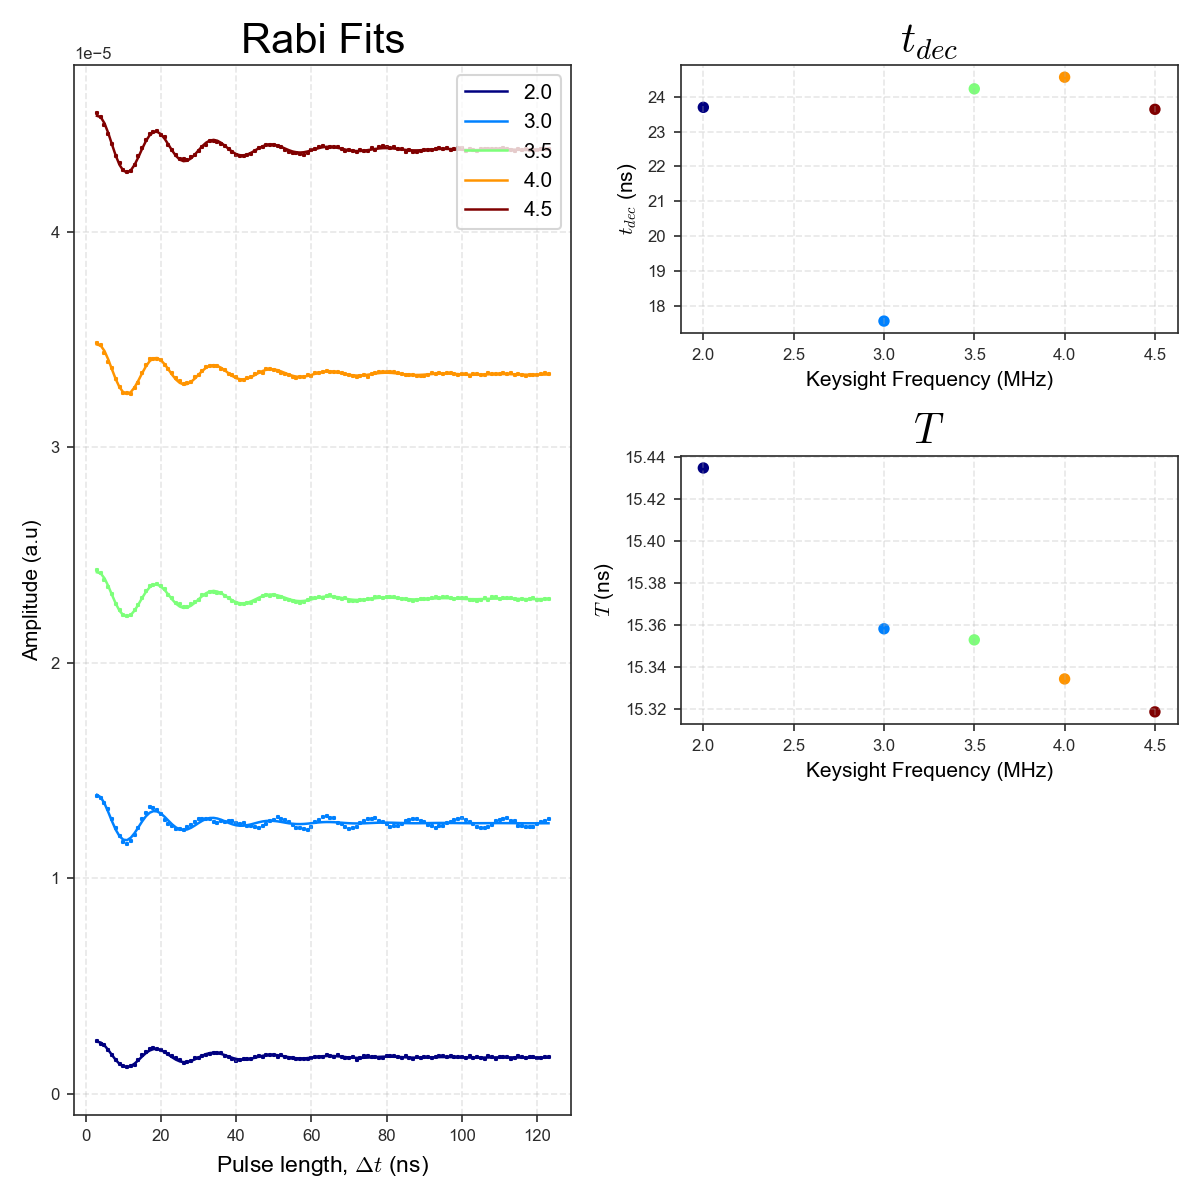

In [143]:
# Summarise the fittings:
SPACING = 0.00001
cmap = plt.cm.jet(np.linspace(0, 1, len(fit_data)))
fit_data = dict(sorted(fit_data.items()))
TRANSMISSION_FILE = "C:/ExperimentBlue/2021-08_photon-source/Ay_16_rabi-freq-sweep_vna-5dBm_transmission.txt"

# Plot T, t_dec for different frequencies and the rabi plots
# fix, ax = plt.subplots(3, 1, figsize=(4,9))
plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 2)

ax0 = plt.subplot(gs[:, 0])
ax0.set_title("Rabi Fits")
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax0.set_ylabel("Amplitude (a.u)", fontsize=10)

ax1 = plt.subplot(gs[0, 1])
ax1.set_title("$t_{dec}$")
ax1.set_xlabel(f"{VARIABLE}", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=10)

ax2 = plt.subplot(gs[1, 1])
ax2.set_title("$T$")
ax2.set_xlabel(f"{VARIABLE}", fontsize=10)
ax2.set_ylabel("$T$ (ns)", fontsize=10)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model(T_DATA, *val), color=cmap[i], label=F_DATA[idx])
    ax0.scatter(T_DATA, i * SPACING + DATA[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[F_DATA[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0]
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap) 

# Plot transmission
# ax3 = plt.subplot(gs[2, 1])
# ax3.set_title("Transmission Spectrum")
# ax3.set_xlabel(VARIABLE, fontsize=10)
# ax3.set_ylabel("|t|", fontsize=10)


# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax3.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='gray', label="Low Power")
# ax3.legend()

# ax32 = ax3.twinx() 
# transmission = np.loadtxt(TRANSMISSION_FILE, skiprows=1)
# selection_mask = np.logical_and(transmission[:, 0] > (unpacked_f[0] * GHz), transmission[:, 0] < unpacked_f[-1] * GHz)
# ax32.plot(transmission[:, 0][selection_mask] / GHz, transmission[:, 1][selection_mask], linewidth=1, color='black', label="Rabi Power")

# ax32.axvline(res_original)
# ax1.axvline(res_original)
# ax2.axvline(res_original)

# ax32.axvline(res_rabi)
# ax1.axvline(res_rabi)
# ax2.axvline(res_rabi)

# ax32.legend(loc='upper left')
# ax3.legend(loc='lower right')
ax0.legend()
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "svg"))
plt.savefig(FILENAME.replace("txt", "pdf"))

# Finding state for SPA measurements

## On resonance -5dBm

In [168]:
# Initial parameters
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_38_rabi-at-select-powers-for-spa-and-digitiser_-5dBm-6.905503G.txt"
with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
T_DATA = data[:,0]
y_data = data[:,1]

RABI_MODEL=rabi_model

<IPython.core.display.Javascript object>


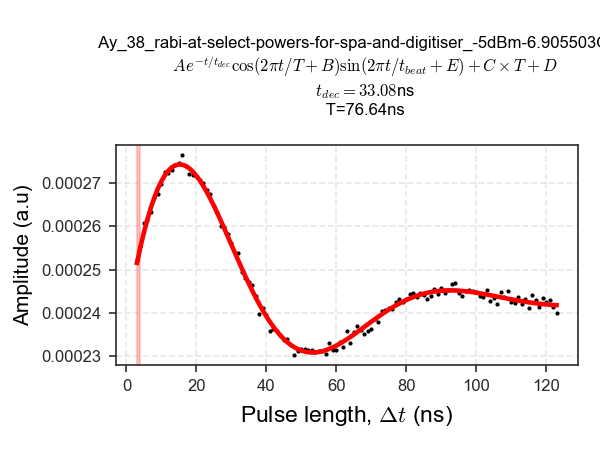

In [173]:
# Initial Guess
cut = (0, 1)
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
raw, = ax.plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax.plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax.plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax.axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax.set_ylabel("Amplitude (a.u)", fontsize=10)
ax.set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    $t_{{dec}} = {popt[0]:.2f}$
    T={popt[1]:.2f}ns
    """, fontsize=8)

plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, 
           A, B, C, D, E, 
           cut, user_toggle, fit_toggle):
    C = C / 10**6
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax.set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        $t_{{dec}} = {popt[0]:.2f}$ns
        T={popt[1]:.2f}ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax.patches = []
    ax.axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax.relim()
    ax.autoscale_view()
    return popt

def load_fit(_):
    fit_data = update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value,
        A_widget.value, B_widget.value, C_widget.value, D_widget.value, E_widget.value, 
        CUT_widget.value, user_toggle_widget.value,  fit_toggle_widget.value)
    
    t_dec_widget.value = fit_data[0]
    T_widget.value = fit_data[1]
    A_widget.value = fit_data[2]
    B_widget.value = fit_data[3]
    C_widget.value = fit_data[4] * 10**6
    D_widget.value = fit_data[5]
    E_widget.value = fit_data[6]
    t_beat_widget.value = fit_data[7] 


    print(f"Stored parameters!{fit_data}")

In [174]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_fit)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[8, 0] = user_toggle_widget
ui[8, 2] = fit_toggle_widget
ui[9, :] = load_parameters_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

Stored parameters![ 1.07040014e+01  7.18880309e+01  4.61906795e-05  8.38348354e+00
 -9.41276304e-08  2.50082422e-04  1.57079633e+00  8.00000000e+03]
Stored parameters![ 3.11279816e+01 -7.69416450e+01 -5.88994227e-05  6.31786187e+00
  2.10658663e-08  2.40018813e-04  1.57079633e+00  8.00000000e+03]
Stored parameters![3.25767849e+01 7.66318334e+01 5.75760518e-05 6.25339530e+00
 1.86118316e-08 2.40231924e-04 1.57079633e+00 8.00000000e+03]


## On 6.915GHz -2dBm

In [175]:
# Initial parameters
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_38_rabi-at-select-powers-for-spa-and-digitiser_-2dBm-6.915G.txt"
with open(FILENAME) as fin:
    data = np.loadtxt(fin, skiprows=1)
T_DATA = data[:,0]
y_data = data[:,1]

RABI_MODEL=rabi_model

 c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py: 828

<IPython.core.display.Javascript object>


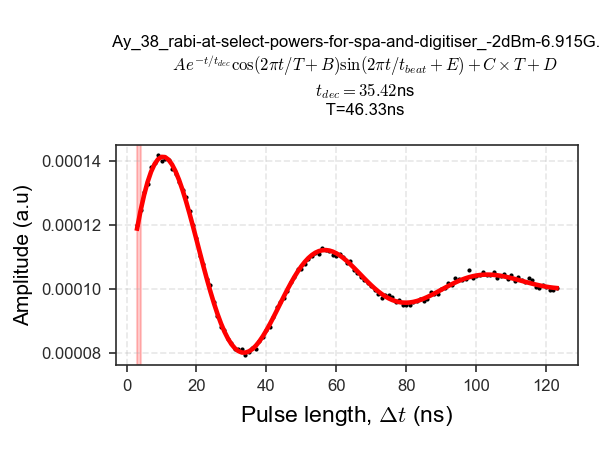

In [176]:
# Initial Guess
cut = (0, 1)
t_dec = 20
T = 35
t_beat = 8000
A = 0.00002
B = 4.44
C = 0
D = 0.0008
E = np.pi / 2

# Fitting
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(1, 1, figsize=(4, 3))
raw, = ax.plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax.plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax.plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax.axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax.set_ylabel("Amplitude (a.u)", fontsize=10)
ax.set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    $t_{{dec}} = {popt[0]:.2f}$
    T={popt[1]:.2f}ns
    """, fontsize=8)

plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, 
           A, B, C, D, E, 
           cut, user_toggle, fit_toggle):
    C = C / 10**6
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax.set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        $t_{{dec}} = {popt[0]:.2f}$ns
        T={popt[1]:.2f}ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax.patches = []
    ax.axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax.relim()
    ax.autoscale_view()
    return popt

def load_fit(_):
    fit_data = update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value,
        A_widget.value, B_widget.value, C_widget.value, D_widget.value, E_widget.value, 
        CUT_widget.value, user_toggle_widget.value,  fit_toggle_widget.value)
    
    t_dec_widget.value = fit_data[0]
    T_widget.value = fit_data[1]
    A_widget.value = fit_data[2]
    B_widget.value = fit_data[3]
    C_widget.value = fit_data[4] * 10**6
    D_widget.value = fit_data[5]
    E_widget.value = fit_data[6]
    t_beat_widget.value = fit_data[7] 


    print(f"Stored parameters!{fit_data}")

In [177]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatText(
#     min=1, max=100,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatText(
#     min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatText(
#     min=10, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatText(
#     min=0, max=0.01, step=0.0001,
    readout_format='.5f',
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatText(
#     min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatText(
#     min=-0.5, max=0.5, 
    step=0.0001,
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_fit)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(11, 4)
ui[0, :] = A_widget
ui[1, :] = C_widget
ui[2, :] = D_widget
ui[3, :] = T_widget
ui[4, :2] = t_dec_widget; ui[4, 2:] = t_beat_widget
ui[5, :2] = B_widget; ui[5, 2:] = E_widget
ui[6, :] = CUT_widget
ui[8, 0] = user_toggle_widget
ui[8, 2] = fit_toggle_widget
ui[9, :] = load_parameters_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=2e-05, description='A', layout=Layout(grid_area='widget001', width='9…

Output()

Stored parameters![ 7.80673154e+01  5.00651653e+01 -1.63174987e-05  3.53756615e+00
 -7.49244333e-08  1.06167682e-04  1.57079633e+00  8.00000000e+03]
Stored parameters![ 3.54233426e+01  4.63269372e+01 -5.52490718e-05  3.09636174e+00
  6.37578676e-09  1.00825047e-04  1.57079633e+00  8.00000000e+03]
Stored parameters![ 3.54166248e+01  4.63284712e+01 -5.52699692e-05  3.09615078e+00
  6.44479257e-09  1.00820436e-04  1.57079633e+00  8.00000000e+03]


# New photon source (Ty)

In [ ]:
FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ay_02_mfield-sweep.vi.txt"

# Fabrication Parameters
RESISTANCE_RT = 5.67*kOhm
JJ_side = 100
#AREA_LOOP = 4.2*um * 5.8*um
L = 40*um
W = 10*um
N = 25

# Fitting Parameters
OFFSET = 0.026
MULTIPLIER = 3.36
EC = ec_interdigitated(L, W, N)
EJ0 = 8.8
FLUX_LIST = np.linspace(-0.2, 0.2, 101)

# loaded
with open(FILENAME) as fin:
    lines = (line for line in fin if not line.startswith('#'))
    experiment_data = np.loadtxt(lines)
experiment_x = (experiment_data[:, 0] - OFFSET) * MULTIPLIER
experiment_y = experiment_data[:, 1]

# Expected
expected = scq.TunableTransmon(
    EJmax=2*eval_expected_ej0(RESISTANCE_RT),
    EC=ec_interdigitated(L, W, N),
    d=0,       # no assymerty
    flux=0.0,  # defaults
    ng=0.0,
    ncut=21
)
expected_01 = expected.get_spectrum_vs_paramvals(param_name='flux',
                                                  param_vals=FLUX_LIST,
                                                  evals_count=2,
                                                  subtract_ground=True
                                                  ).energy_table[:, 1]
# Fitting
fitted = scq.TunableTransmon(
    EJmax=2*EJ0,
    EC=EC,
    d=0,       # no assymerty
    flux=0.0,  # defaults
    ng=0.0,
    ncut=21
)
fitted_01 = fitted.get_spectrum_vs_paramvals(param_name='flux',
                                                  param_vals=FLUX_LIST,
                                                  evals_count=2,
                                                  subtract_ground=True
                                                  ).energy_table[:, 1]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
expected_plot, = ax.plot(FLUX_LIST, expected_01,
        linestyle="-",
        color=MY_COLOURS["DarkRed"],
        label="Expected",
        linewidth=2, 
        )
fitted_plot, = ax.plot(FLUX_LIST, fitted_01,
        linestyle="-",
        color=MY_COLOURS["DarkBlue"],
        label="Fitted",
        linewidth=8,
        alpha=0.2
        )

experiment_plot, = ax.plot(experiment_x, experiment_y,
        marker="o",
        color=MY_COLOURS["DarkBlue"],
        markeredgecolor="C2",
        label="Raw",
        markeredgewidth="0.4", markersize=4, alpha=0.95,
        linestyle="")

ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.set_ylabel("$\omega/2\pi$ (GHz)", fontsize=15)
ax.set_title(f"$E_C={EC:.2f}\,$GHz, $E_{{J0}}={EJ0:.2f}\,$GHz, $R={eval_resitance_from_ej0(JJ_side, JJ_side, EJ0):.2f}$k$\Omega$", fontsize=16)
ax.legend()
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "pdf"))